<a href="https://colab.research.google.com/github/RobinMikeal/Geol558/blob/main/GEOL558_Proj_1_Unsupervised_ML_Final_Robin_Mikeal_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Stratigraphic Clusters based on Estimated Hydraulic Conductivity (K):**

 Exploratory Data Analysis for an Unsupervised Machine Learning Exercise

By: Robin Mikeal



# Abstract

High resolution data provides a tremendous amount of detail that serves as a line of evidence to understand what the stratigraphy of the unconsolidated material above bedrock may be.  However, the data is so dense that it is impossible to interpret in its native form.  Additionally, it is useful to consider the distribution of the high resolution data across the entire site.  This study will evaluate the use of unsupervised machine learning methods on high resolution down-borehole data obtained from a hydraulic profiling tool (HPT).  The feature of interest will be estimated hydraulic conductivity (K).  This study illustrates that standard clustering models like Kmeans and HDBScan do not fit the shape of the distribution of the data that occur in nature represented by down-hole boring log charts.  However, clustering models that honor banded, or linear geometries would be a better fit for identifying potential clusters of associated data. Unfortunately, even the more common models that evaluate for banded geometries, such as Gaussian Mixture and Spectral Clustering offer limited confidence in being able to consistently select clusters that align to suspected groupings.          

# 1.0  Introduction

Field geologists gather enormous amounts of observational and measurement data while studying the subsurface.  Downhole probes are lowered that return readings about the formation at the sub-foot scale.  Thus, thousands of datapoints may be returned when examining an entire site with many locations. All this data from similar locations may be a good candidate for unsupervised machine learning, where models can review unstructured data and identify patterns and clusters.  Specifically, this study will examine hydraulic profiling tool (HPT)-generated estimated hydraulic conductivity (K).  Based on sonic borehole cuttings from the same site, it is known that the site has approximately 7 discrete layers that are mostly laterally continuous.  However, the thicknesses of each of these seven layers are not consistent as the depositional setting is a glaciated bedrock surface overlain with glacial till, then a series of overland flow/channel deposits.

It will be interesting to see what unsupervised machine learning makes of the estimated K (EstK).  The domain knowledge of the "likely seven discrete, mostly continuous depositional layers" will be helpful in cluster evaluation and would have served as the upper cluster limit.  But the cluster number will be further reduced since the HPT EstK probe was not activated until after reaching the top of the third layer.  Additionally, the HPT was stopped at bedrock, which represents the 7th layer.  Therefore, the ideal cluster number would be 4, although multiple iterations of varying cluster targets for machine learning and different unsupervised models will be evaluated.


# Installs and Imports

In [37]:
!pip install hdbscan
!pip install --upgrade scikit-learn


In [38]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import iqr  # Import iqr function if you are not sure of number of histogram bins
from sklearn.cluster import KMeans
import hdbscan
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# File Path

In [39]:
# Specify the path to your CSV file in Github
file_path = 'https://raw.githubusercontent.com/RobinMikeal/Geol558/main/HPT_P2P3_KClass.csv'  # Replace with your file path

# 2.0  Data Processing and Cleaning

In [40]:
# Read the CSV file into a pandas DataFrame

df = pd.read_csv(file_path)
print(df.head())  # Print the first few rows of the DataFrame

      Location_ID  Depth_ft  Elev_GS  Elev_K  EstK_ft_day
0  114-P2-IRM-11D     20.00     14.1   -5.90         31.0
1  114-P2-IRM-11D     20.05     14.1   -5.95         18.0
2  114-P2-IRM-11D     20.10     14.1   -6.00         15.0
3  114-P2-IRM-11D     20.15     14.1   -6.05         10.0
4  114-P2-IRM-11D     20.20     14.1   -6.10          6.9


In [41]:
df.shape

(54512, 5)

In [42]:
# Calculate descriptive statistics
descriptive_stats = df.describe()
# Round all values to 2 decimal places
descriptive_stats = descriptive_stats.round(2)
print("\nDescriptive Statistics:")
print(descriptive_stats)


Descriptive Statistics:
       Depth_ft   Elev_GS    Elev_K  EstK_ft_day
count  54512.00  54512.00  54512.00     54512.00
mean      39.94     12.14    -27.81        39.22
std       16.92      1.41     17.05        38.76
min        3.05      9.10    -78.70         0.10
25%       26.30     11.00    -41.10         6.60
50%       39.20     11.80    -26.95        32.00
75%       53.30     13.30    -13.95        58.00
max       89.80     15.00      8.15       150.00


In [43]:
# for df count number of unique Location_ID

print(df['Location_ID'].nunique())

51


## 2.1  Data Description

This shows that there are 54,512 records in this dataset with 5 columns, or features.  One of the features is Location_ID.  As shown by the dataframe snippet, many records may have the same location ID.  The unique command reveals that there are 51 unique location IDs.  Much of this evaluation will consider the data based on unique Location IDs.  However some analysis will consider the distribution of the entire dataset.  



##2.2 Feature Engineering

There may be some other columns that will be useful for consideration.  For example, the change in value of K between consecutive points per location, and the consecutive and cumulative EstK value, that is, a column based cumulative distribution and normalized cumulative distribution.  For the change in EstK between consecutive intervals, you may wonder if slope would be more appropriate.  If your depth intervals are not consistent, then yes, slope would be better. But for this dataset all the intervals are all exactly 0.05 ft.  So, slope would not be as helpful here.  

To create the columns we need, we will group by location, sort based on location, then sort based on depth and create three new columns, Diff_EstK, CDF_K, and CDFKN.  Then, for each unique Location_ID, we will calculate the difference between the EstK_ft_day and the consecutive change in Depth_ft.  For CDF_K, for each Location_ID, we will sum the consecutive EstK_ft_day values.



In [44]:
# Group data by 'Location_ID'
grouped = df.groupby('Location_ID')

results = []

for location_id, group_df in grouped:
    # Sort by 'Depth_ft' within each group in ascending order
    group_df = group_df.sort_values('Depth_ft', ascending=True)

    # Calculate consecutive differences in EstK_ft_day
    group_df['Diff_EstK'] = group_df['EstK_ft_day'].diff().fillna(0)

    # Calculate CDF_K
    group_df['CDF_K'] = group_df['EstK_ft_day'].cumsum()

    results.append(group_df)

# Concatenate the results
df = pd.concat(results)

# Calculate the max CDF_K for each Location_ID
max_cdf_k = df.groupby('Location_ID')['CDF_K'].transform('max')

# Create a new column CDF_KN that divides the CDF_K by the max CDF_K of the entire group
df['CDF_KN'] = df['CDF_K'] / max_cdf_k

df.head(4)

,Location_ID,Depth_ft,Elev_GS,Elev_K,EstK_ft_day,Diff_EstK,CDF_K,CDF_KN
0,114-P2-IRM-11D,20.00,14.1,-5.90,31.0,0.0,31.0,0.000809
1,114-P2-IRM-11D,20.05,14.1,-5.95,18.0,-13.0,49.0,0.001279
2,114-P2-IRM-11D,20.10,14.1,-6.00,15.0,-3.0,64.0,0.001670
3,114-P2-IRM-11D,20.15,14.1,-6.05,10.0,-5.0,74.0,0.001931


Now, we will create a new working dataframe to summarize our data which will be populated with summaries of data.  A historical report showed that three clusters were calculated based on the CDF:  C1, C2, and C3, where C1 is most permeable, and C3 is least permeable.  However, the methods for calculating this were purely mathematical without modeling.  For purposes of comparison, I have recreated the mathematical formula used to define C1, C2, and C3 in the code cells below which results in the assignment of "C1, C2, or C3" based on its EstK value, position within the borehole, and the min and max EstK of each unique borehole, as well as the overall min and max of the entire dataset.  This will start with a C1 dataframe, and then be followed by C2, and C3, then the final summary, then re-compilation into the main data frame.  

In [45]:
# pseudocode: create a new dataframe called dfCDF, and populate with a value called C1_thk which is calculated by grouping by Location_ID from df, finding the value from CDF_KN that is equal to 0.9 and giving the corresponding value from Depth_ft, to 2 decimal places, then create second column called C1_thkperc in dfCDF, which is calculated by taking the C1_thk value and dividing by the maximum  of Depth_ft per grouped Location_ID in df, then create a third column in dfCDF called C1K_target, which is calculated by taking (the max of all values in df EstK_ft_day, minus the min of all values in df EstK_ft_day)/(the max of all values in df EstK_ft_day by grouped location ID, minus the min of all values in df EstK_ft_day by grouped location ID)*(looking up the 0.9 in the CDF_KN of the grouped Location_ID in df, and giving the corresponding EstK_ft_day to four decimal places, then adding this value to the minimum value in EstK_ft_day of the group), then finally subtracting the the value of the minimum value of EstK_ft_day from the entire dataset.

# Create an empty DataFrame to store the results
dfCDF = pd.DataFrame()

#Regroup the dataframe since the previous cell overwrote the grouped variable.
grouped = df.groupby('Location_ID')

for location_id, group_df in grouped:
    # Find the value from CDF_KN that is closest to 0.9
    target_cdf_kn = 0.9
    idx = (np.abs(group_df['CDF_KN'] - target_cdf_kn)).idxmin()
    c1_thk = group_df.loc[idx, 'Depth_ft']

    # Calculate C1_thkperc
    c1_thkperc = c1_thk / group_df['Depth_ft'].max()

    # Calculate C1K_target
    max_estk = df['EstK_ft_day'].max()
    min_estk = df['EstK_ft_day'].min()
    max_estk_group = group_df['EstK_ft_day'].max()
    min_estk_group = group_df['EstK_ft_day'].min()

    # Find EstK_ft_day corresponding to CDF_KN closest to 0.9
    idx_estk = (np.abs(group_df['CDF_KN'] - target_cdf_kn)).idxmin()
    estk_at_09_cdf = group_df.loc[idx_estk, 'EstK_ft_day']

    c1k_target = ((max_estk - min_estk) / (max_estk_group - min_estk_group)) * (estk_at_09_cdf) + min_estk_group - min_estk

    # Append results to the dfCDF DataFrame
    dfCDF = pd.concat([dfCDF, pd.DataFrame({'Location_ID': [location_id],
                                            'C1_thk': [round(c1_thk, 2)],
                                            'C1_thkperc': [c1_thkperc],
                                            'C1K_target': [round(c1k_target,4)]})], ignore_index=True)

dfCDF.head(4)

,Location_ID,C1_thk,C1_thkperc,C1K_target
0,114-P2-IRM-11D,65.40,0.979042,70.0
1,114-P2-IRM-15D,56.45,0.839405,41.0
2,114-P2-IRM-17D,61.80,0.901532,19.0
3,114-P2-IRM-1I,61.75,0.958107,150.0


Next, we will replicate the code for the C2 formula, and create a C2 summary dataframe.

In [46]:
# pseudocode:  create a new the dataframe called dfCDF2, populate with a value called C2_thk which is calculated by grouping by Location_ID from df, finding the value from CDF_KN that is equal to 0.99 and giving the corresponding value from Depth_ft, to 2 decimal places, then create second column called C2_thkperc in dfCDF, which is calculated by taking the C2_thk value and dividing by (the maximum  of Depth_ft per grouped Location_ID in df minus the corresponding group value in C1_thkperc from dfCDF), then create a third column in dfCDF called C2K_target, which is calculated by taking (the max of all values in df EstK_ft_day, minus the min of all values in df EstK_ft_day)/(the max of all values in df EstK_ft_day by grouped location ID, minus the min of all values in df EstK_ft_day by grouped location ID)*(looking up the 0.99 in the CDF_KN of the grouped Location_ID in df, and giving the corresponding EstK_ft_day to four decimal places, then adding this value to the minimum value in EstK_ft_day of the group), then finally subtracting the the value of the minimum value of EstK_ft_day from the entire dataset.

# Create dfCDF2
dfCDF2 = pd.DataFrame()

#Regroup the dataframe since the previous cell overwrote the grouped variable.
grouped = df.groupby('Location_ID')

for location_id, group_df in grouped:
    # Find the value from CDF_KN that is closest to 0.99
    target_cdf_kn = 0.99
    idx = (np.abs(group_df['CDF_KN'] - target_cdf_kn)).idxmin()
    c2_thk = group_df.loc[idx, 'Depth_ft']

    # Calculate C2_thkperc
    c2_thkperc = c2_thk / (group_df['Depth_ft'].max() - dfCDF[dfCDF['Location_ID'] == location_id]['C1_thkperc'].values[0])

    # Calculate C2K_target
    max_estk = df['EstK_ft_day'].max()
    min_estk = df['EstK_ft_day'].min()
    max_estk_group = group_df['EstK_ft_day'].max()
    min_estk_group = group_df['EstK_ft_day'].min()

    # Find EstK_ft_day corresponding to CDF_KN closest to 0.99
    idx_estk = (np.abs(group_df['CDF_KN'] - target_cdf_kn)).idxmin()
    estk_at_99_cdf = group_df.loc[idx_estk, 'EstK_ft_day']

    c2k_target = ((max_estk - min_estk) / (max_estk_group - min_estk_group)) * estk_at_99_cdf + min_estk_group - min_estk

    # Append results to the dfCDF2 DataFrame
    dfCDF2 = pd.concat([dfCDF2, pd.DataFrame({'Location_ID': [location_id],
                                            'C2_thk': [round(c2_thk, 2)],
                                            'C2_thkperc': [c2_thkperc],
                                            'C2K_target': [round(c2k_target, 4)]})], ignore_index=True)

dfCDF2.head(4)

,Location_ID,C2_thk,C2_thkperc,C2K_target
0,114-P2-IRM-11D,66.65,1.012595,150.0
1,114-P2-IRM-15D,64.10,0.965207,7.3
2,114-P2-IRM-17D,68.00,1.005196,47.0
3,114-P2-IRM-1I,64.25,1.011940,150.0


In [47]:
# pseudocode: create a new the dataframe called dfCDF3, populate with a value called C3_thk which is calculated by grouping by Location_ID from df, finding the value from CDF_KN that is equal to 0.99 and giving the corresponding value from Depth_ft, to 2 decimal places, then create second column called C3_thkperc in dfCDF, which is calculated by taking 1 minus (the sum of the C1_thkperc from dfCDF value and the C2_thkperc from dfCDF2), then create a third column in dfCDF called C3K_target, which is calculated by taking the min of all values in df EstK_ft_day.

# Create dfCDF3
dfCDF3 = pd.DataFrame()

#Regroup the dataframe since the previous cell overwrote the grouped variable.
grouped = df.groupby('Location_ID')

for location_id, group_df in grouped:
    # Find the value from CDF_KN that is closest to 0.99
    target_cdf_kn = 0.99
    idx = (np.abs(group_df['CDF_KN'] - target_cdf_kn)).idxmin()
    c3_thk = group_df.loc[idx, 'Depth_ft']

    # Calculate C3_thkperc
    c3_thkperc = 1 - (dfCDF[dfCDF['Location_ID'] == location_id]['C1_thkperc'].values[0] + dfCDF2[dfCDF2['Location_ID'] == location_id]['C2_thkperc'].values[0])

    # Calculate C3K_target
    c3k_target = df['EstK_ft_day'].min()

    # Append results to the dfCDF3 DataFrame
    dfCDF3 = pd.concat([dfCDF3, pd.DataFrame({'Location_ID': [location_id],
                                            'C3_thk': [round(c3_thk, 2)],
                                            'C3_thkperc': [c3_thkperc],
                                            'C3K_target': [round(c3k_target, 4)]})], ignore_index=True)

dfCDF3.head(4)

,Location_ID,C3_thk,C3_thkperc,C3K_target
0,114-P2-IRM-11D,66.65,-0.991637,0.1
1,114-P2-IRM-15D,64.10,-0.804613,0.1
2,114-P2-IRM-17D,68.00,-0.906728,0.1
3,114-P2-IRM-1I,64.25,-0.970047,0.1


Now, we will merge all columns from dfCDF, dfCDF2, and dfCDF3 into a new dataframe called dfLabels.

In [48]:
# Merge the dataframes
dfLabels = pd.merge(dfCDF, dfCDF2, on='Location_ID', how='outer')
dfLabels = pd.merge(dfLabels, dfCDF3, on='Location_ID', how='outer')
dfLabels.head(4)

,Location_ID,C1_thk,C1_thkperc,C1K_target,C2_thk,C2_thkperc,C2K_target,C3_thk,C3_thkperc,C3K_target
0,114-P2-IRM-11D,65.40,0.979042,70.0,66.65,1.012595,150.0,66.65,-0.991637,0.1
1,114-P2-IRM-15D,56.45,0.839405,41.0,64.10,0.965207,7.3,64.10,-0.804613,0.1
2,114-P2-IRM-17D,61.80,0.901532,19.0,68.00,1.005196,47.0,68.00,-0.906728,0.1
3,114-P2-IRM-1I,61.75,0.958107,150.0,64.25,1.011940,150.0,64.25,-0.970047,0.1


Last, most machine learning methods require the removal of blank data.  So let's check to make that we don't have blanks or NaNs in the dataset for any of our key features.  This step was completed, but none were present.


Now, this next step isn't really a supervised model.  But it could be used for a supervised model in the future.  It is called supervised because I am assigning labels based on the mathematical formula above.  A new column called CClass is created and populated as 1 if EstK_ft_day is more than the corresponding C1K_target for the corresponding Location ID in dfLabels, populated as 2 if EstK_ft_day is between the corresponding C1K_target for the corresponding Location ID in dfLabels and the corresponding C2K_target for the corresponding Location ID in dfLabels, or populated as 3 if EstK_ft_day is less than the corresponding C2K_target for the corresponding Location ID in dfLabels.  Then we will take a look at the plots to see how well the math does on its own.


In [49]:
dfSupervised = df.copy()

# Merge df and dfLabels based on 'Location_ID'
dfSupervised = pd.merge(dfSupervised, dfLabels, on='Location_ID', how='left')

# Create the 'CClass' column based on the conditions
def assign_cclass(row):
    if row['EstK_ft_day'] > row['C1K_target']:
        return 1
    elif row['C1K_target'] >= row['EstK_ft_day'] >= row['C2K_target']:
        return 2
    elif row['EstK_ft_day'] < row['C2K_target']:
        return 3
    else:
        return np.nan  # Handle cases that don't fit the criteria

dfSupervised['CClass'] = dfSupervised.apply(assign_cclass, axis=1)

#3.0  Visualizing the Data

Let's start by looking at this K by location in the same way that we would look at it on a strip log down hole by inverting the Y axis to represent depth below ground surface.  We'll also make sure to normalize the Y axis to the maximum depth of any location so that it will be easier to compare graph to graph.  Note, for all charts plotted by location, only the first 4 are shown for ease of codebook navigation.  This can easily be adjusted to iterate through all locations as needed.

### Figure 1.  Scatter Plot By Location (Descending Depth)

In [50]:
# Function to calculate gradient change
def calculate_gradient_change(x, y):
    with np.errstate(divide='ignore', invalid='ignore'):
        gradients = np.true_divide(np.diff(y), np.diff(x))
        gradients[~np.isfinite(gradients)] = np.nan  # replace inf and -inf with NaN
    return gradients


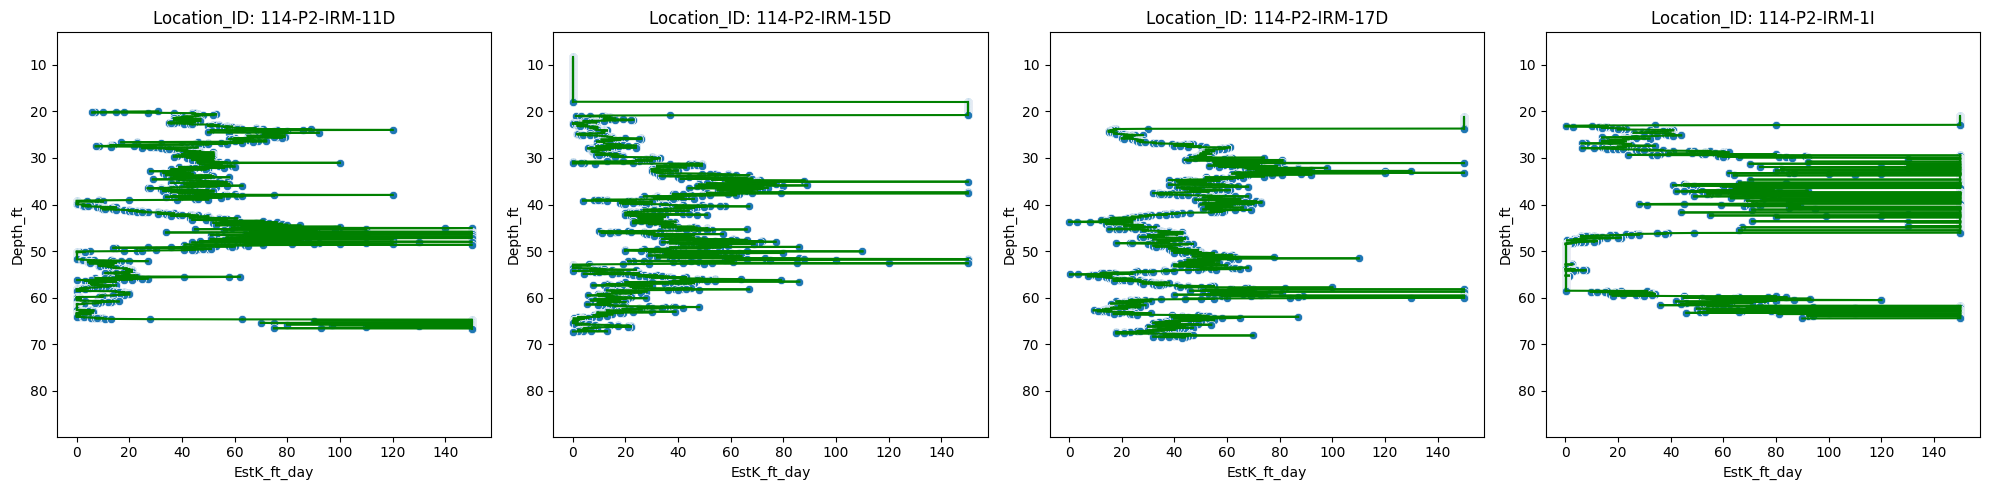

In [51]:
#Regroup the dataframe since the previous cell overwrote the grouped variable.
grouped = df.groupby('Location_ID', sort=False)

# Determine the number of rows needed for the subplot grid
num_groups = 51
num_cols = 4
num_rows = (num_groups + num_cols - 1) // num_cols

#Find the common Y-axis limits
y_min = df['Depth_ft'].min() # Use df directly instead of grouped
y_max = df['Depth_ft'].max() # Use df directly instead of grouped

# Iterate over each group and create a scatter plot in a subplot
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))  # Adjust figure size
axes = axes.flatten()

for i, ((name, group), ax) in enumerate(zip(grouped, axes)): #Add i, for enumerate counter
    if i >= 4:  # If 4 plots are already shown, break out of loop
        break
    sns.scatterplot(data=group, x='EstK_ft_day', y='Depth_ft', ax=ax)
    ax.set_title(f'Location_ID: {name}')

    # Invert the Y-axis to have the origin at the upper left
    ax.invert_yaxis()

    # Set the same Y-axis limits for all subplots
    ax.set_ylim(y_max, y_min)

    # Calculate gradient changes
    gradient_changes = calculate_gradient_change(group['EstK_ft_day'].values, group['Depth_ft'].values)

    # Plot gradient changes
    for j in range(len(gradient_changes)):
        ax.plot([group['EstK_ft_day'].values[j], group['EstK_ft_day'].values[j+1]],
                [group['Depth_ft'].values[j], group['Depth_ft'].values[j+1]], 'g-')

# Remove any unused subplots
for i in range(num_groups, len(axes)): #change in range to delete plots outside 4
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()



Now, try the same style of scatter plot but plot by difference between the consecutive K values and the depth.

### Figure 2.  Scatter Plot By Location By Difference in Estimated K (Descending Depth)

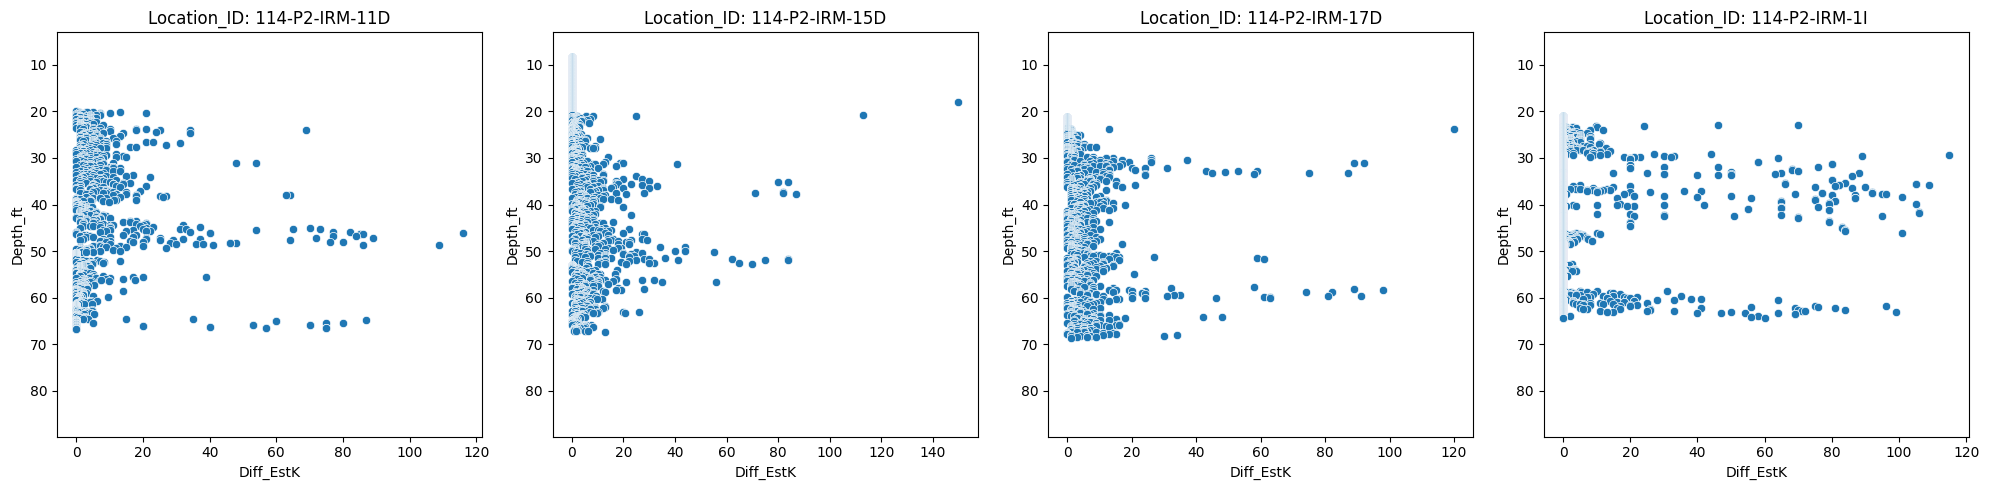

In [52]:
# Take the absolute value of Diff_EstK
df['Diff_EstK'] = df['Diff_EstK'].abs()

#Regroup the dataframe since the previous cell overwrote the grouped variable.
grouped = df.groupby('Location_ID', sort=False)

# Iterate over each group and create a scatter plot in a subplot
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))  # Adjust figure size
axes = axes.flatten()

for i, ((name, group), ax) in enumerate(zip(grouped, axes)): #Add i, for enumerate counter
    if i >= 4:  # If 4 plots are already shown, break out of loop
        break
    sns.scatterplot(data=group, x='Diff_EstK', y='Depth_ft', ax=ax)
    ax.set_title(f'Location_ID: {name}')

    # Invert the Y-axis to have the origin at the upper left
    ax.invert_yaxis()

    # Set the same Y-axis limits for all subplots
    ax.set_ylim(y_max, y_min)

# Remove any unused subplots
for i in range(num_groups, len(axes)): #change in range to delete plots outside 4
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

These charts look similar but Figure 1 shows a more consistent distribution, and look less erratic than Figure 2.  Taking the difference between points "normalizes" the data.  This will be helpful in the clustering that will be used below.  However, we will evaluate both dataset combinations using unsupervised learning for purposes on demonstration.

Now let's take a look at the data from my "supervised" data frame.  I've also set up a color dictionary to make sure my colors stay consitent.

In [53]:
color_dict = {
    1: '#7DF9FF',  # C1: Electric blue
    2: '#93C572',  # C2: Pistachio
    3: 'peru'      # C3: Orangish brown (unchanged)
}

## Figure 3. The Simple Math Plots Based on Normalized CDF EstK Values by Depth

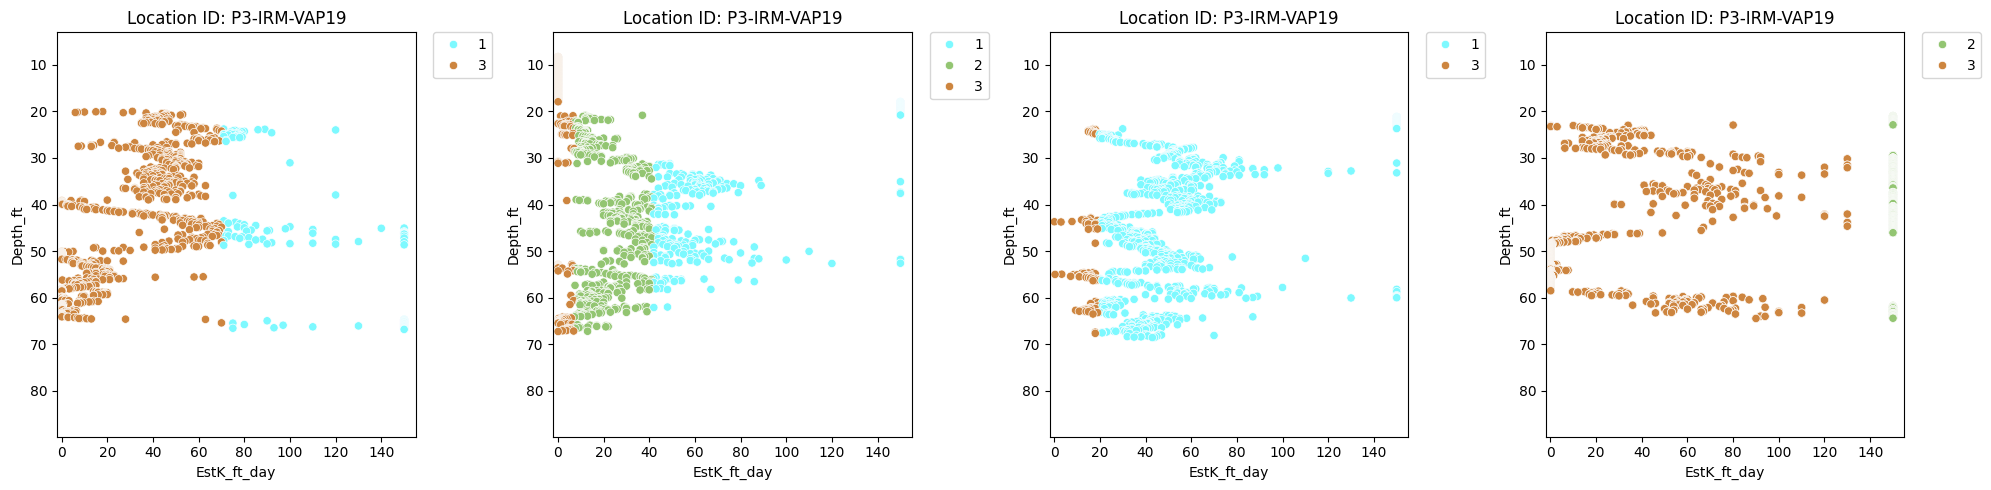

In [54]:
# Calculate min and max values for x-axis
x_min = dfSupervised['EstK_ft_day'].min()
x_max = dfSupervised['EstK_ft_day'].max()

#Regroup the dataframe since the previous cell overwrote the grouped variable.
# AND make sure that 'CClass' is included in the grouping
grouped = dfSupervised.groupby('Location_ID', sort=False)

# Iterate over each group and create a scatter plot in a subplot
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))  # Adjust figure size
axes = axes.flatten()

for i, ((name, group), ax) in enumerate(zip(grouped, axes)): #Add i, for enumerate counter
    if i >= 4:  # If 4 plots are already shown, break out of loop
        break
    # The 'CClass' column should now be present in group
    sns.scatterplot(x='EstK_ft_day', y='Depth_ft', hue='CClass', data=group, ax=ax, palette=color_dict)
    ax.set_title(f'Location ID: {location_id}')
    ax.set_ylim(y_max, y_min)  # Invert y-axis and set same scale
    ax.set_xlim(-2, 155)  # Set the same x-axis limits

    # Add legend and adjust position (values may need fine-tuning)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Remove any unused subplots
for i in range(num_groups, len(axes)): #change in range to delete plots outside 4
    fig.delaxes(axes[i])


plt.tight_layout()
plt.show()

Whoa - that's ugly.  Figure 3 does not look like down-hole geology.  That looks bathymetry on its side.  Remember, this is not clustering, this is pseudoclassifying.  We took math formulas to define labels that are then displayed based on their class.  But the math formula method does not reveal classes or clusters that align to depositional geometry.  It is purely based on the EstK values, and their cumulative values relative to dataset.  That is what gives the look of vertical bands above.  Defining depositional units is more about identifying the beginning of change in data groups.  Where does a marked change happen vertically with depth.  At the point where the data suddenly increases for a few readings, then begins to decrease, represents the cluster.  So the ideal classification or clusters that we will be looking for are horizontal bands of colors initiated based on sudden changes in the EstK.

**Also note**, the colors of these class groups are consistent.  1 is always blue, 2 is always green, and 3 is always brown.  This is an important observation for comparison purposes later in the unsupervised clustering evaluation.  Because 1, 2, and 3 are mathematically calculated, they are fixed and consistent across all plots.

So before moving into unsupervised machine learning, let's consider one more mathematical operation on this classed data.  

What if we looked for the maximum response per set interval?  If we grouped the depths into consecutive 3 ft intervals, then sought the maximum EstK, and applied it label to all other points within the interval, that might bring us closer to the geologic structure that we are after.

In [55]:
# Create 'Depth_Grp' column
dfSupervised['Depth_Grp'] = (dfSupervised['Depth_ft'] // 3) * 3

# Group by 'Location_ID' and 'Depth_Grp' to find the most frequent 'CClass'
df_maxc = dfSupervised.groupby(['Location_ID', 'Depth_Grp'])['CClass'].agg(lambda x: x.value_counts().index[0] if not x.empty else np.nan).reset_index(name='MaxC')

# Merge the results back into the original DataFrame
dfSupervised = pd.merge(dfSupervised, df_maxc, on=['Location_ID', 'Depth_Grp'], how='left')

dfSupervised.head(4)

,Location_ID,Depth_ft,Elev_GS,Elev_K,EstK_ft_day,Diff_EstK,CDF_K,CDF_KN,C1_thk,C1_thkperc,C1K_target,C2_thk,C2_thkperc,C2K_target,C3_thk,C3_thkperc,C3K_target,CClass,Depth_Grp,MaxC
0,114-P2-IRM-11D,20.00,14.1,-5.90,31.0,0.0,31.0,0.000809,65.4,0.979042,70.0,66.65,1.012595,150.0,66.65,-0.991637,0.1,3,18.0,3
1,114-P2-IRM-11D,20.05,14.1,-5.95,18.0,-13.0,49.0,0.001279,65.4,0.979042,70.0,66.65,1.012595,150.0,66.65,-0.991637,0.1,3,18.0,3
2,114-P2-IRM-11D,20.10,14.1,-6.00,15.0,-3.0,64.0,0.001670,65.4,0.979042,70.0,66.65,1.012595,150.0,66.65,-0.991637,0.1,3,18.0,3
3,114-P2-IRM-11D,20.15,14.1,-6.05,10.0,-5.0,74.0,0.001931,65.4,0.979042,70.0,66.65,1.012595,150.0,66.65,-0.991637,0.1,3,18.0,3


## Figure 4. Simple Math of Normalized CDF of EstK by Depth: Extended to Max for Set Intervals

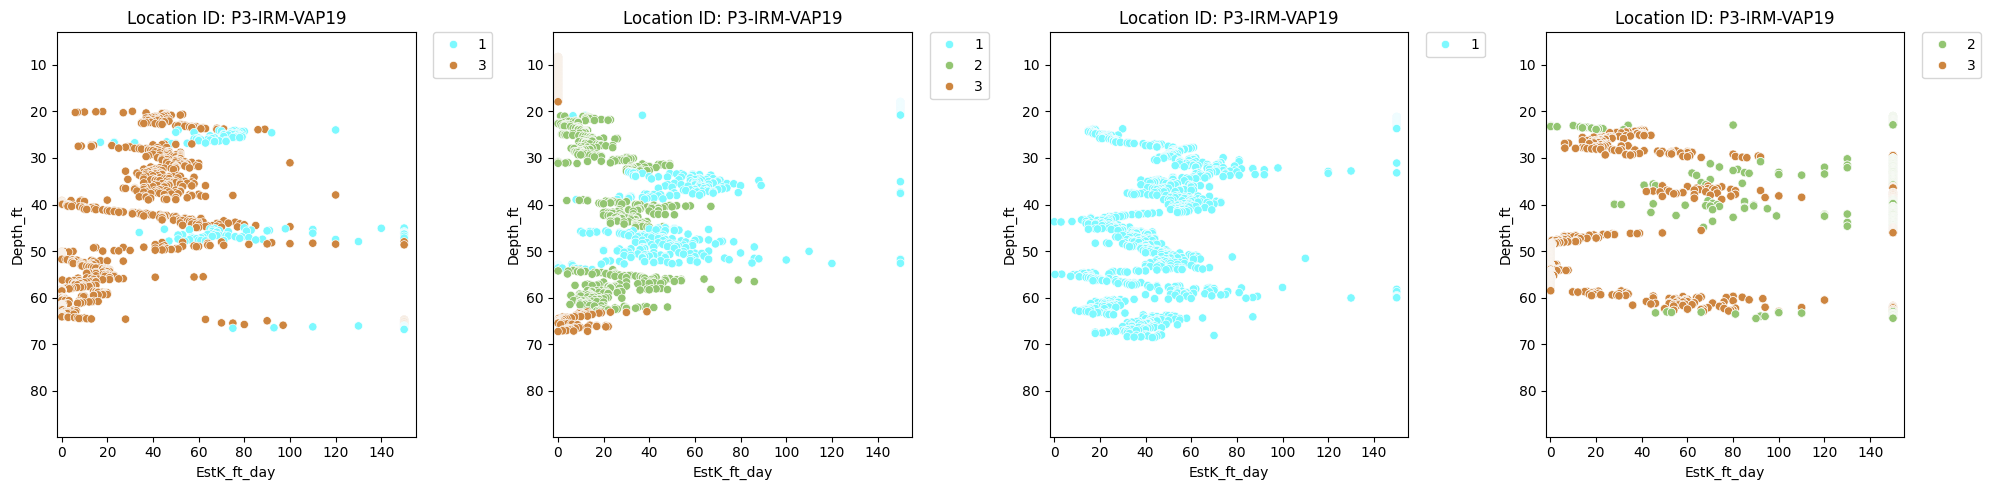

In [56]:
# Iterate over each group and create a scatter plot in a subplot
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))  # Adjust figure size
axes = axes.flatten()

#Regroup the dataframe using dfSupervised to include 'MaxC' in each group
# AND make sure that 'CClass' is included in the grouping
grouped = dfSupervised.groupby('Location_ID', sort=False)

for i, ((name, group), ax) in enumerate(zip(grouped, axes)): #Add i, for enumerate counter
    if i >= 4:  # If 4 plots are already shown, break out of loop
        break
    sns.scatterplot(x='EstK_ft_day', y='Depth_ft', hue='MaxC', data=group, ax=ax, palette=color_dict)
    ax.set_title(f'Location ID: {location_id}')
    ax.set_ylim(y_max, y_min)
    ax.set_xlim(-2, 155)

    # Add legend and adjust position (values may need fine-tuning)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Remove any unused subplots
for i in range(num_groups, len(axes)): #change in range to delete plots outside 4
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Figure 4 is looks much more like geology in a downhole boring log because the classes are horizontal now rather than vertical.  But there are still some odd outliers in the method of the application of the labels. For example, why is everything in P3-IRM-VAP19 all blue??? These might have to be addressed on a location-by-location basis, which would not be very efficient.  But it is good enough to serve as a reference for our next phase, preparing for machine learning methods.  

Next, we'll consider the cumulative distribution function of the EstK values as plotted by NumPy.  You may wonder, why calculate it manually, and plot that as a scatter against depth versus just the CDF of Estimated K on its own. Well, this is just two different ways to explore the data.  And it may be helpful.  

NOTE: I plotted all of the K data in one CDF function, but that created a CDF that looked more like a seismogram than a smooth sigmoid shape.  This is primarily because the data when lumped together as a whole is not normal. But the sigmoids are roughly more smooth when they are plotted by location as shown in Figure 5.

## Figure 5. Cumulative Distribution Function (CDF) By Location

In [57]:
# Function to create CDF plot for each unique Location_ID
def create_cdf_plot(df):
    unique_locations = df['Location_ID'].unique()
    num_locations = len(unique_locations)

    # Create subplots with 4 columns, but limit to 4 plots
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))  # Changed nrows to 1
    axes = axes.flatten()

    # Iterate through only the first 4 locations
    for i, location in enumerate(unique_locations[:4]):  # Sliced unique_locations
        location_df = df[df['Location_ID'] == location].sort_values(by='Depth_ft')

        # Calculate cumulative distribution of EstK_ft_day
        values, base = np.histogram(location_df['EstK_ft_day'], bins=40)
        cumulative = np.cumsum(values)

        # Plot CDF
        axes[i].plot(base[:-1], cumulative / cumulative[-1], label=f'Location_ID {location}')

        # Calculate and plot the median and mean
        # Changed to location_df to access the correct data for median
        median = location_df['EstK_ft_day'].median()
        mean = location_df['EstK_ft_day'].mean()
        axes[i].axvline(median, color='r', linestyle='--', label='Median')
        axes[i].axvline(mean, color='g', linestyle='-', label='Mean')

        # Label the median
        axes[i].text(median, 0.5, f'Median: {median:.2f}', color='r', ha='center')

        axes[i].set_xlabel('EstK_ft_day')
        axes[i].set_ylabel('Cumulative Distribution Function')
        axes[i].set_title(f'CDF for {location}')
        axes[i].grid(True)
        axes[i].legend()

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


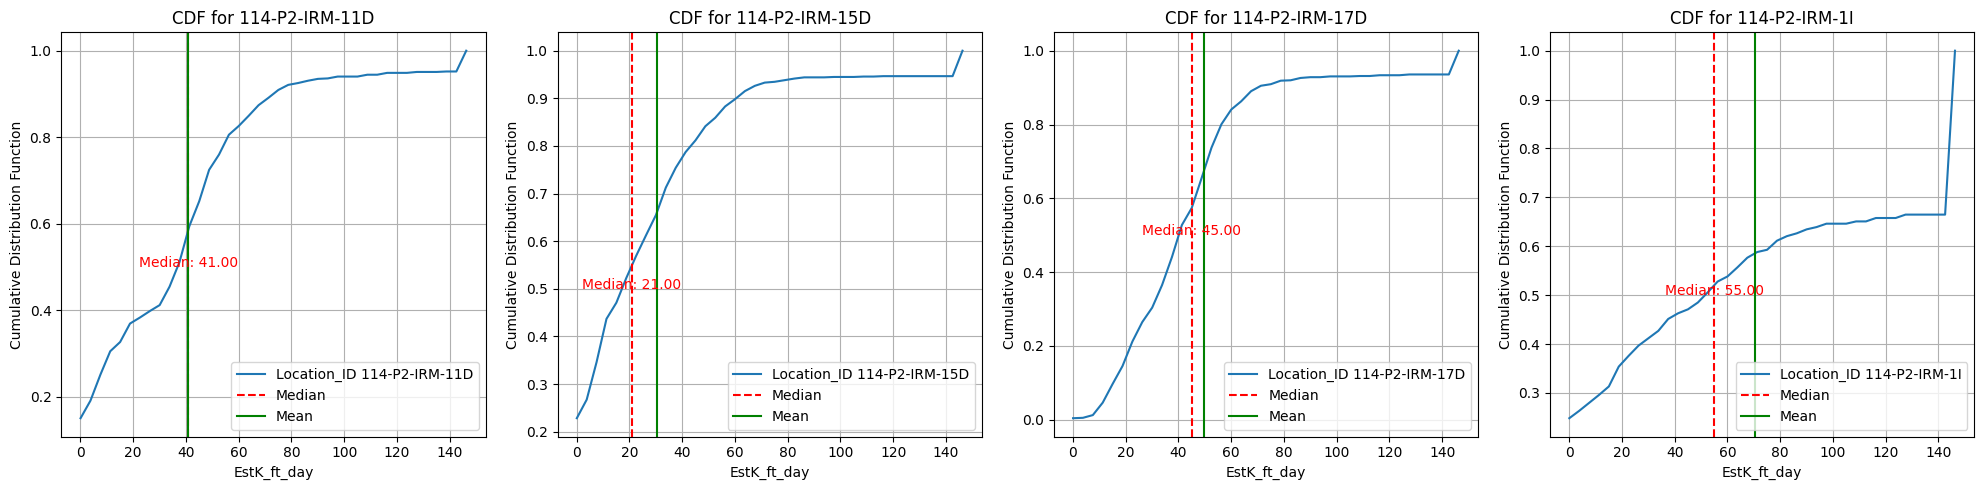

In [58]:
# Create CDF plot
create_cdf_plot(df)

Figure 5 displays that the data does not make a smooth sigmoid, S-shaped curve, for the Difference in EstK. What does that suggest? Likely, the distribution is not normal. That is not surprising because this data represents estimated K which is not normal since sedimentary deposition is not normal. It can vary depending on changing climate and tectonic conditions.

What about a CDF of the differences of consecutive K?

##Figure 6.  CDF of Differences of Consecutive Estimated K By Location

In [59]:
# Function to create CDF plot for each unique Location_ID
def create_cdf_plotD(df):
    unique_locations = df['Location_ID'].unique()
    num_locations = len(unique_locations)

    # Create subplots with 4 columns, but limit to 4 plots
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
    axes = axes.flatten()

    # Iterate through only the first 4 locations
    for i, location in enumerate(unique_locations[:4]):  # Sliced unique_locations
        location_df = df[df['Location_ID'] == location].sort_values(by='Depth_ft')

        # Calculate cumulative distribution of the Difference of the Consecutive EstK
        values, base = np.histogram(location_df['Diff_EstK'], bins=40)
        cumulative = np.cumsum(values)

        # Plot CDF
        axes[i].plot(base[:-1], cumulative / cumulative[-1], label=f'Location_ID {location}')

        # Calculate and plot the median and mean
        median = location_df['Diff_EstK'].median()
        mean = location_df['Diff_EstK'].mean()
        axes[i].axvline(median, color='r', linestyle='--', label='Median')
        axes[i].axvline(mean, color='g', linestyle='-', label='Mean')

        axes[i].set_xlabel('Diff_EstK')
        axes[i].set_ylabel('Cumulative Distribution Function')
        axes[i].set_title(f'CDF for {location}')
        axes[i].grid(True)
        axes[i].legend()

    plt.tight_layout()
    plt.show()


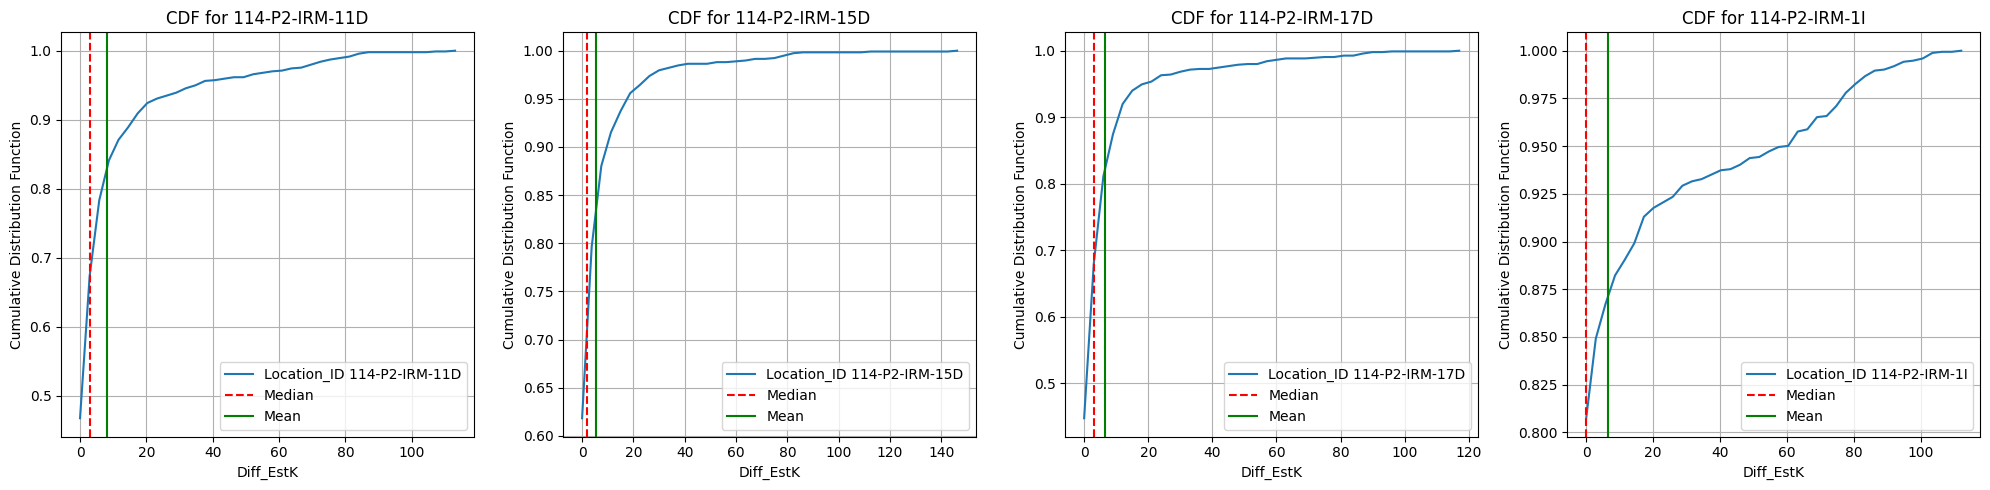

In [60]:
# Create CDF plot
create_cdf_plotD(df)

So as shown in Figure 6, the data does not make a smooth sigmoid, S-shaped curve, for the Difference in EstK either.   

The original CDF of Estimated K (Figure 5) showed the closest look to the sigmoid curves and the means and medians correctly reflect the distribution of the actual dataset.  

The final CDF based on the difference of consecutive estimated K values (Figure 6) showed a nice curve, but again the means and medians were not clearly helpful in understanding the dataset.  But this may be helpful later in the study.

So, understanding that this data is not normal, what can we say about the expected type of material that we may encounter on the site?

We could evaluate this using the likelihood that the EstK will be less than 0.5 of the original CDF (Figure 5), and compare those to the mean, and median of distribution at each location in its own data frame.    

## List 1.  Maximum Estimated K per location where CDF < 0.5 and Summary Stats

In [61]:
# Function to find the maximum EstK_ft_day below 0.5 of the CDF and calculate median and quartiles
def find_max_estk_below_cdf_threshold(df):
    unique_locations = df['Location_ID'].unique()
    results = []
    for location in unique_locations:
        location_df = df[df['Location_ID'] == location].sort_values(by='Depth_ft')
        values, base = np.histogram(location_df['EstK_ft_day'], bins=40)
        cumulative = np.cumsum(values)
        cdf = cumulative / cumulative[-1]

        # Find the maximum EstK_ft_day where CDF < 0.5
        max_estk = -1  # Initialize with a value that will be replaced
        for i in range(len(base) - 1):
            if cdf[i] < 0.5:
                max_estk = max(max_estk, base[i])

        # Calculate median and quartiles
        median = location_df['EstK_ft_day'].median()
        q1 = location_df['EstK_ft_day'].quantile(0.25)
        mean = location_df['EstK_ft_day'].quantile(0.5)
        q3 = location_df['EstK_ft_day'].quantile(0.75)

        results.append({
            'Location_ID': location,
            'Max_EstK_ft_day at CDF 0.5': round(max_estk, 2),
            'Median': round(median, 2),
            'Q1': round(q1, 2),
            'Q3': round(q3, 2),
            'Mean': round(mean, 2)
        })
    return pd.DataFrame(results)

In [62]:
# Find max EstK_ft_day below 0.5 CDF threshold and calculate median and quartiles
results_df = find_max_estk_below_cdf_threshold(df)
results_df.head(4)

,Location_ID,Max_EstK_ft_day at CDF 0.5,Median,Q1,Q3,Mean
0,114-P2-IRM-11D,33.83,41.0,11.0,55.0,41.0
1,114-P2-IRM-15D,15.09,21.0,6.0,41.0,21.0
2,114-P2-IRM-17D,37.58,45.0,29.0,57.0,45.0
3,114-P2-IRM-1I,48.82,55.0,4.1,150.0,55.0


List 1 illustrates that the likelihood of the maximum K value at 0.5 of the CDF is less than the mean or median for each location.  Which should be used for comparison across datasets?  Let's keep digging.

In [63]:
# Calculate descriptive statistics
descriptive_statsCDF = results_df.describe()
# Round all values to 2 decimal places
descriptive_statsCDF = descriptive_statsCDF.round(2)
print("\nDescriptive Statistics of CDF, Median, Mean, and Quartiles:")
print(descriptive_statsCDF)


Descriptive Statistics of CDF, Median, Mean, and Quartiles:
       Max_EstK_ft_day at CDF 0.5  Median     Q1      Q3   Mean
count                       51.00   51.00  51.00   51.00  51.00
mean                        26.70   32.28   9.19   57.17  32.28
std                         13.76   13.72   9.66   23.43  13.72
min                          0.10    7.55   0.10   26.00   7.55
25%                         15.09   21.00   0.10   43.50  21.00
50%                         26.33   33.00   6.60   52.00  33.00
75%                         37.01   41.50  16.00   65.00  41.50
max                         60.06   64.00  34.00  150.00  64.00



Next, let's create a bar chart of the above code block results of maximum EstK that is less than 0.5 of the CDF on the Y axis and grouped location ID on the X axis.
## Figure 7.  Bar Chart of Maximum Estimated K by Location where CDF < 0.5

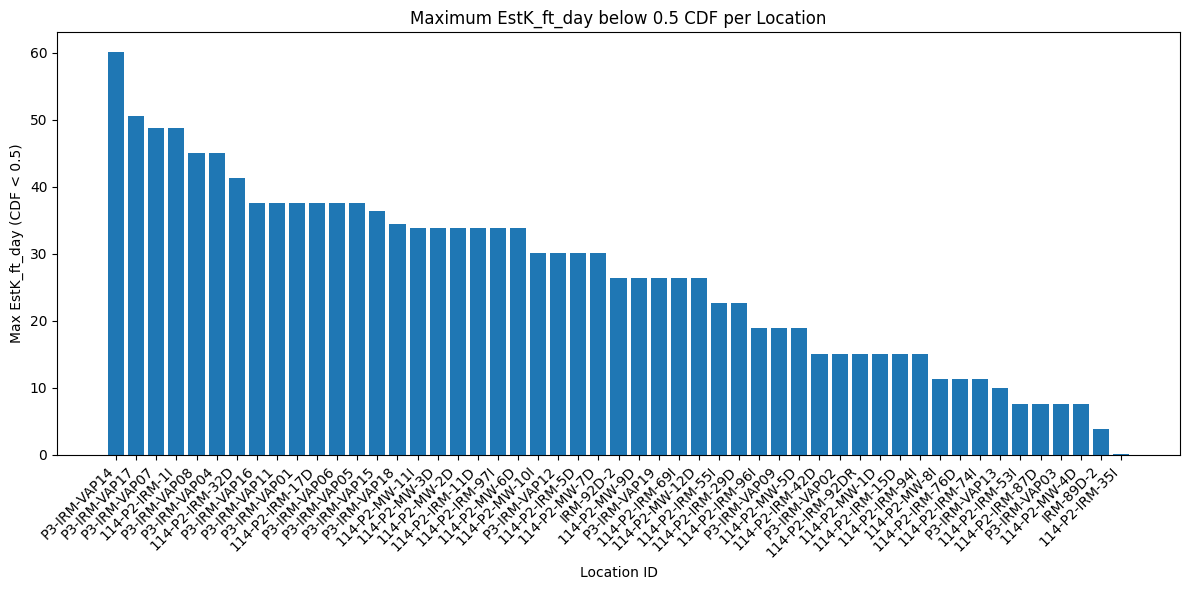

In [64]:


# Sort the DataFrame by Max_EstK_ft_day in decreasing order
results_df = results_df.sort_values(by='Max_EstK_ft_day at CDF 0.5', ascending=False)

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(results_df['Location_ID'], results_df['Max_EstK_ft_day at CDF 0.5'])
plt.xlabel('Location ID')
plt.ylabel('Max EstK_ft_day (CDF < 0.5)')
plt.title('Maximum EstK_ft_day below 0.5 CDF per Location')
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for readability and make font smaller
plt.tight_layout()
plt.show()

Practically, Figure 7 shows which locations may have more permeable material by volume.  This is helpful because it helps the geologist who may be designing a remediation program to better predict injection capacity or retardation.  So, in P3-IRM-VAP14 as the EstK were accumulated, by the time that half of the values were accumulated, the maximum value of EstK was about 60.  This does not mean that the average value is 60, it just means that there were not many high readings of EstK in the first half of the borehole.  What does that mean for 114-P2-IRM-35I at the other end of the graph?  When half of the borehole data had been collected, the maximum value of EstK was near zero!  That is some very dense, low permeable material.  Or it is an error in the log.  In either case, this visualization has given us a quick way to identify a potential error becasue it allows us to compare the data to each other location quickly.  Often the logs are provided by the contractor in a one-by-one page report and each log is scaled so that you can see the variation within the single hole.  This is not helpful if you forget to look at the scale.  This eliminates that potential interpretation error.

So is there another way that we can describe the distribution? For example, we could look at the likelihood that the Est K result is below 50.

## Figure 8. Likelihood of Estimated K results that are < 50.

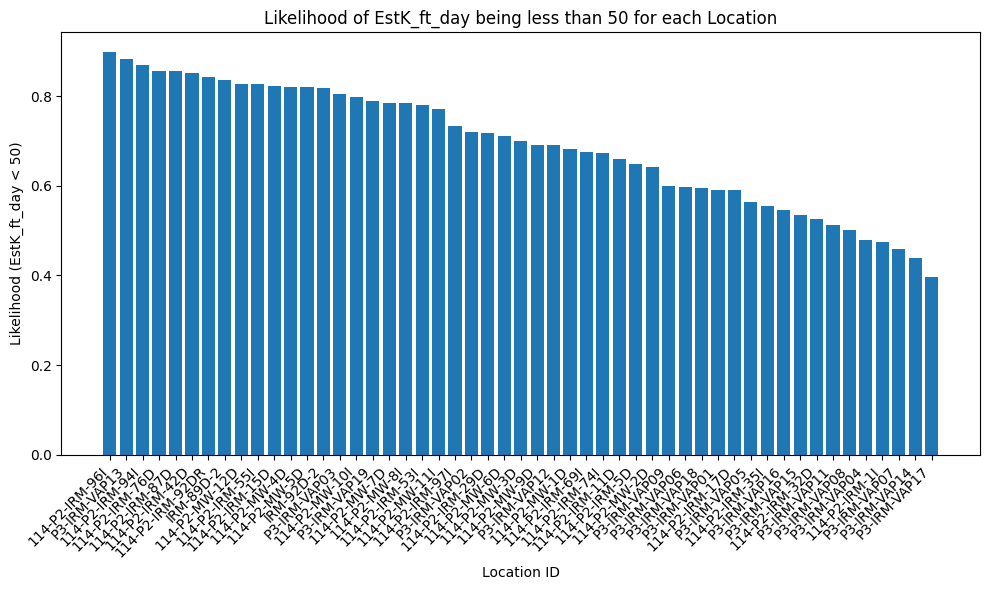

In [65]:
#Regroup the dataframe since the previous cell overwrote the grouped variable.
grouped = df.groupby('Location_ID')

# Calculate the likelihood of EstK_ft_day < 50 for each group
likelihoods = grouped['EstK_ft_day'].apply(lambda x: (x < 50).mean())

# Convert the likelihoods to a DataFrame for easier plotting
likelihoods_df = likelihoods.reset_index()
likelihoods_df.columns = ['Location_ID', 'Likelihood']

# Sort the DataFrame by Likelihood in decreasing order
likelihoods_df = likelihoods_df.sort_values(by='Likelihood', ascending=False)

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(likelihoods_df['Location_ID'], likelihoods_df['Likelihood'])
plt.xlabel("Location ID")
plt.ylabel("Likelihood (EstK_ft_day < 50)")
plt.title("Likelihood of EstK_ft_day being less than 50 for each Location")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

Figure 8 shows an inverse relationship to that show in Figure 7.  So locations whose maximum EstK when the CDF is at 0.5 is a larger value, like P3-IRM-VAP14, these locations appear ranked at the bottom of this graph.  This means there is more permeable material by volume per location (as indicated before), and it has a lower liklihood for the Estimated K value to be less than 50.  But remember this is for the whole borehole (the whole CDF range, not just the first half).  So locations like 114-P2-IRM-35I have just over a 50% likelihood to have a value greater than 50 EstK, but that certainly wasn't in the first half of the borehole.  This suggests that the second half of the borehole must have had higher EstK values.    

Overall, this suggests that there is about a 50% likelihood that at any location, there will be material that has lower permeability (<50 estK).  So those low permeability pockets show up everywhere.  That could suggest a continuous depositional layer that varies in thickness across the site.  

Would a probability density function tell the same story? Could we examine this as a total batch - all the data at the same time to see the distribution?
The Probability Density Function will show the skewed nature of the distribution more clearly.


## Figure 9.  Probability Density Function of the Entire Dataset Estimated K

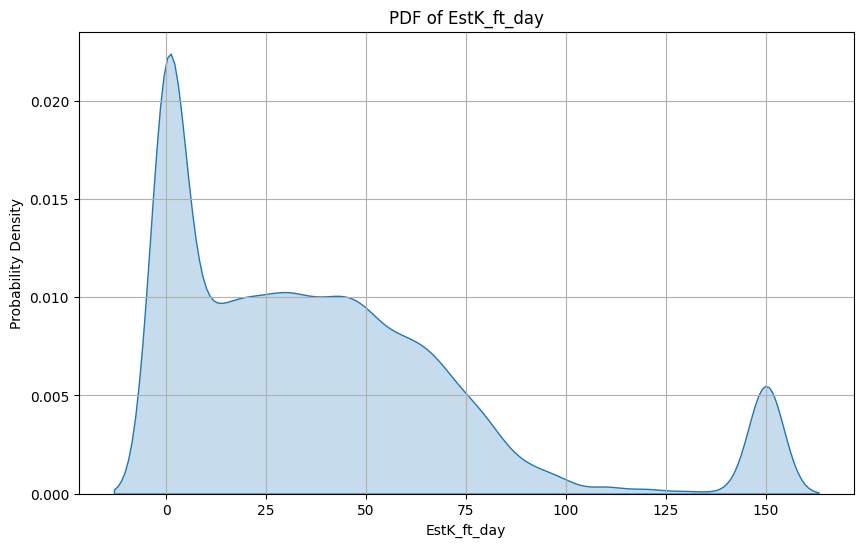

In [66]:
# Select the column for which you want to create the PDF
column_name = 'EstK_ft_day'

# Create the PDF plot using seaborn's kdeplot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.kdeplot(df[column_name], fill=True)  # Use kdeplot for PDF
plt.xlabel(column_name)
plt.ylabel('Probability Density')
plt.title(f'PDF of {column_name}')
plt.grid(True)
plt.show()

This confirms that the distribution is not normal and is skewed right.  

Would it be appropriate to log-transform the data?
## Figure 10.  PDF of the Log-transformed Estimated K

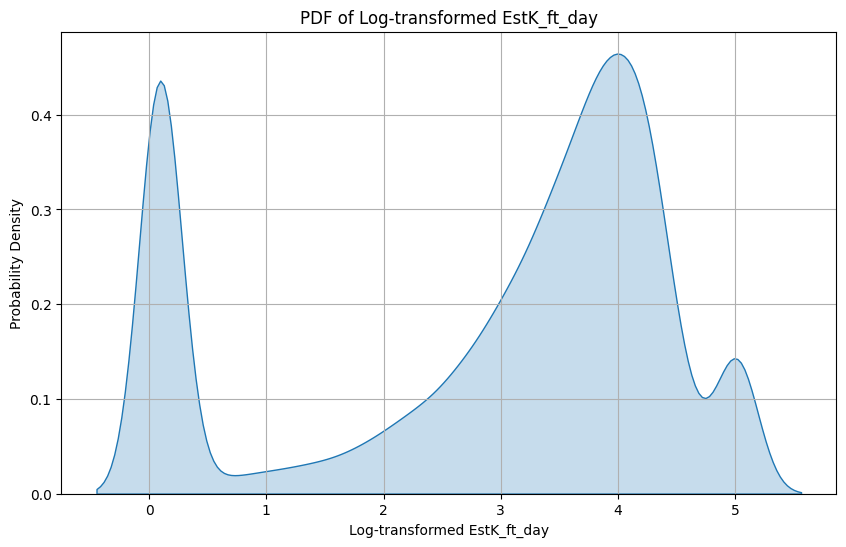

In [67]:
# Create a copy of the DataFrame to avoid modifying the original data
df_log = df.copy()

# Log-transform the 'EstK_ft_day' column, handling zero values
df_log[column_name] = np.log1p(df_log[column_name])  # log1p(x) = log(1 + x)

# Create the PDF plot using seaborn's kdeplot
plt.figure(figsize=(10, 6))
sns.kdeplot(df_log[column_name], fill=True)
plt.xlabel(f'Log-transformed {column_name}')  # Update x-axis label
plt.ylabel('Probability Density')
plt.title(f'PDF of Log-transformed {column_name}')
plt.grid(True)
plt.show()

So, that doesn't really help.  So for now, we will leave the data in its raw form and continue.  

Based on the raw PDF then, what are the probabilities at certain intervals?

## List 2.  Probablities at Select Intervals

In [68]:
# Based on this PDF what is the probability that EstK_ft_day is 25, 50, 75, 100, 125, and 150

# Define the values of EstK_ft_day you are interested in
values_of_interest = [25, 50, 75, 100, 125, 150]

# Calculate the probabilities
probabilities = {}
for value in values_of_interest:
  # Use the value_counts method to count the occurrences
  count = df[df['EstK_ft_day'] == value].shape[0]
  # Use the total number of rows for probability
  probability = count / df.shape[0]
  probabilities[value] = probability

#print(probabilities)

# Calculate probabilities using a kernel density estimation (KDE) plot for smoother probabilities.
from scipy.stats import gaussian_kde

# Calculate the KDE of the EstK_ft_day data
density = gaussian_kde(df['EstK_ft_day'])
kde_probabilities = {}

for value in values_of_interest:
    kde_probabilities[value] = density(value)[0]

#kde_probabilities
# Print the probabilities in sentences, rounded to the thousandths place.
for value, probability in probabilities.items():
  print(f"The probability that the Estimated K would be {value} is {probability:.3f}")

The probability that the Estimated K would be 25 is 0.009
The probability that the Estimated K would be 50 is 0.010
The probability that the Estimated K would be 75 is 0.006
The probability that the Estimated K would be 100 is 0.003
The probability that the Estimated K would be 125 is 0.000
The probability that the Estimated K would be 150 is 0.060


Figure 9 and List 2 demonstrate that there are higher probabilities for a lower EstK, except for the spikes at 150. In other words, this further supports that more of the data are in the lower to medium ranges of EstK (low to medium permeability).  Therfore, from the depositional perspective this suggests that there is more low to medium permeable material than high, but there are certain layers (or lenses) of highly permeable material.

What if we created a PDF plot per location?

## Figure 11.  PDF Plot Per Location


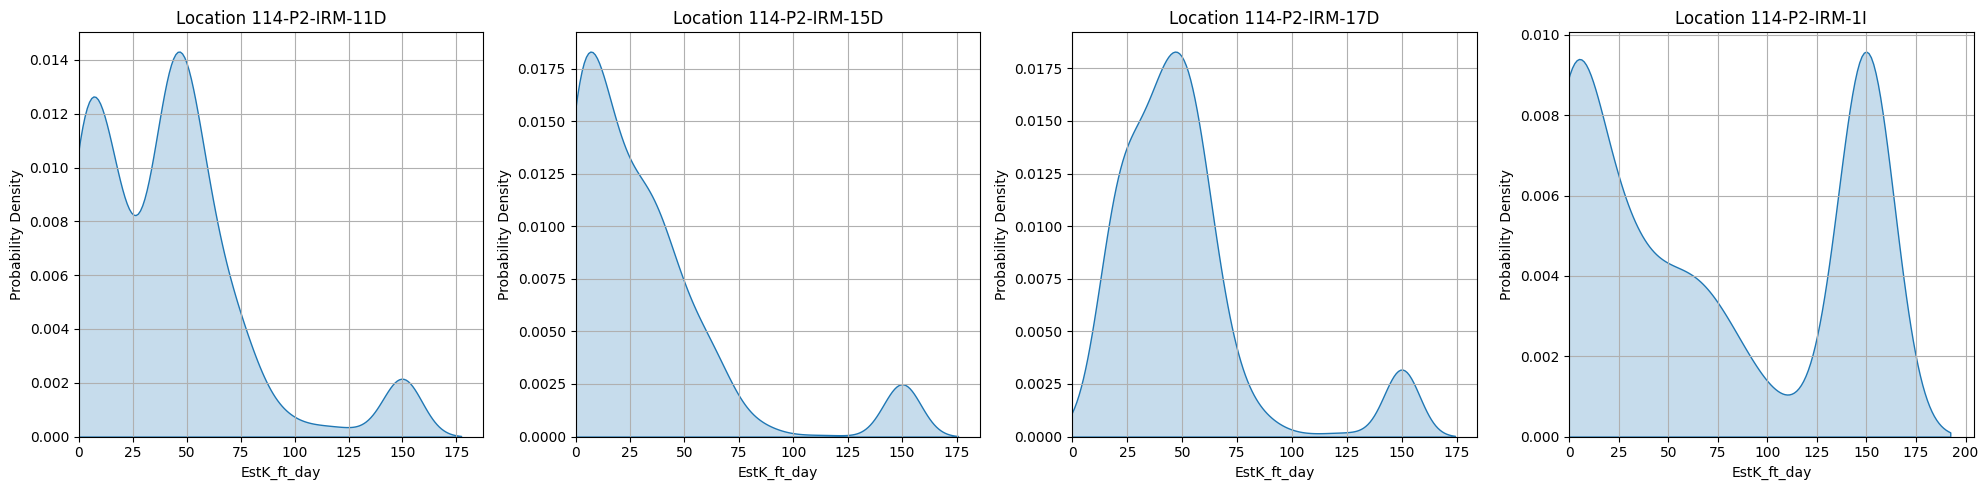

In [69]:
# Get unique Location_IDs
unique_locations = df['Location_ID'].unique()

# Create subplots with 4 columns, but limit to 4 plots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))  # Changed nrows to 1
axes = axes.flatten()

# Plot PDF for each unique Location_ID, limiting to the first 4
for i, location in enumerate(unique_locations[:4]):  # Sliced unique_locations
    subset = df[df['Location_ID'] == location]
    sns.kdeplot(subset['EstK_ft_day'], ax=axes[i], fill=True)
    axes[i].set_title(f'Location {location}')
    axes[i].set_xlabel('EstK_ft_day')
    axes[i].set_ylabel('Probability Density')
    axes[i].grid(True)
    axes[i].set_xlim(left=0)  # Start X-axis at 0

plt.tight_layout()
plt.show()


These PDFs are interesting on a location-by-location basis because it shows that the data is non-normal, the variation between locations since they are normalized by the maximum probability density, and the direction of skewness for each location.  Again, this is not a surprise because as a geologic deposit, you would not really expect a normal distribution over time.  It is going to vary based on depositional setting and climate.  But we are also not seeing very strongly consistent PDFs between locations, meaning that the lithology and measured Est K varies horizontally in thickness from location to location.  In some locations we see clear bimodal distributions, whereas others are trimodal, or just one crest.  Does this suggest a lack of lateral continuity of K-zones?  Maybe, or it could confirm that the thicknesses of potentially laterally continuous layers vary greatly across the site.  The first three graphs of Figure 11 suggests less high EstK, meaning thinner highly permeable layers.  The fourth graph suggest more high EstK values, so this could potentially indicate thicker sandy layers of higher permeability.

One more way to consider the distributions is with a basic histogram.  Varying the bin number can be helpful to see the patterns.  You can also consider the distribution of other features like the depth itself to evaluate whether most of the locations achieved the same depth or vary.  This is important because if there is a lot of variation in the depths, then this may help in understanding where depositional zones may be thinner than others (if all zones are laterally continuous across the site).


## Figure 12.  Histograms of Entire Dataset Estimated and Depths  

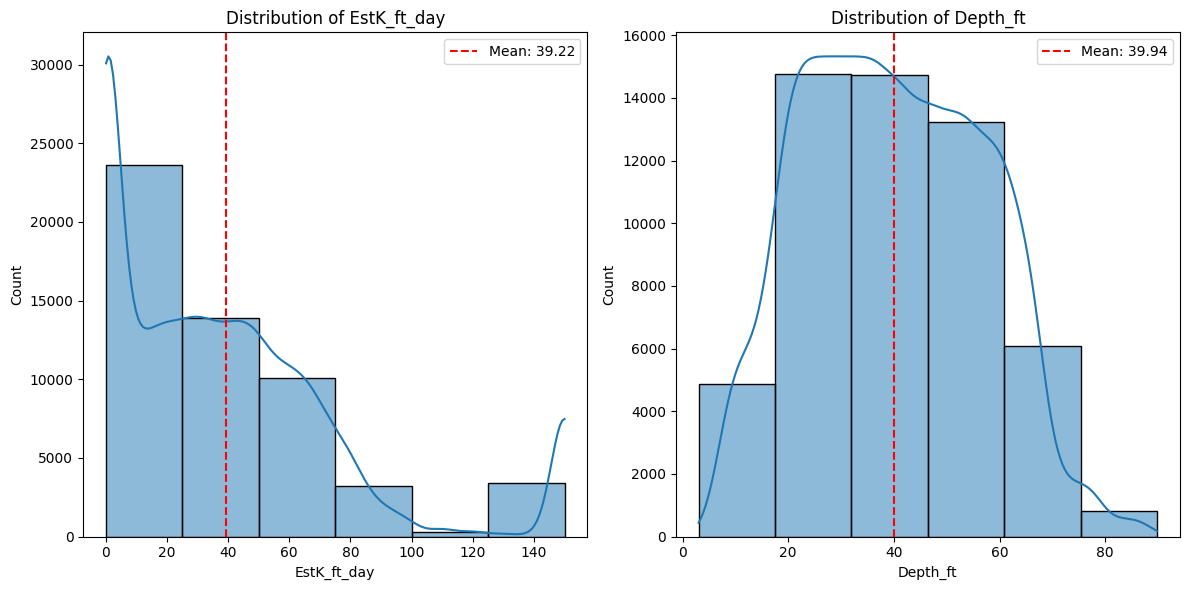

In [70]:
# Calculate means and round to 2 decimal places
mean_estk = round(df['EstK_ft_day'].mean(), 2)
mean_depth = round(df['Depth_ft'].mean(), 2)

# Create subplots with 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Histogram of EstK_ft_day
num_bins_estk = 6
sns.histplot(df['EstK_ft_day'], kde=True, bins=num_bins_estk, ax=axes[0])
axes[0].axvline(mean_estk, color='r', linestyle='--', label=f'Mean: {mean_estk}')
axes[0].set_title('Distribution of EstK_ft_day')
axes[0].legend()

# Histogram of Depth_ft
num_bins_depth = 6
sns.histplot(df['Depth_ft'], kde=True, bins=num_bins_depth, ax=axes[1])
axes[1].axvline(mean_depth, color='r', linestyle='--', label=f'Mean: {mean_depth}')
axes[1].set_title('Distribution of Depth_ft')
axes[1].legend()

plt.tight_layout()
plt.show()


After trying a number of different bins, 20, 2... 6 seemed to best fit the curve with enough detail.  I attempted to use:  This rule is more robust to outliers and considers the interquartile range (IQR) of the data.
bins = int(2 * IQR(data) / (len(data)**(1/3))) (where IQR is the interquartile range function)
Freedman-Diaconis is reportedly a good choice for datasets with varying spread or potential outliers.  However, this resulted in just 2 bins, and was not very helpful.  So instead, I visually inspected the KDE curve and chose the number of bins manually based on the shape of the curve.  The distribution of EstK data within the full dataset confirms more low to medium EstK, therefore more low to medium permeable materials, and lesser high permeabe materials.  The depth histogram reveals that most of the borings represent 20 to 60 ft depth to bedrock.  The presence of so many borings that have thin overburden (20-30 ft thick) suggest the possibility of many thin layers if the layers are laterally continuous.  

The last thing to consider is whether we are missing any other potential connection between other variables. A correlation matrix helps to reveal other potential pairs to evaluate.

## Figure 13.  Correlation Matrix of Variables


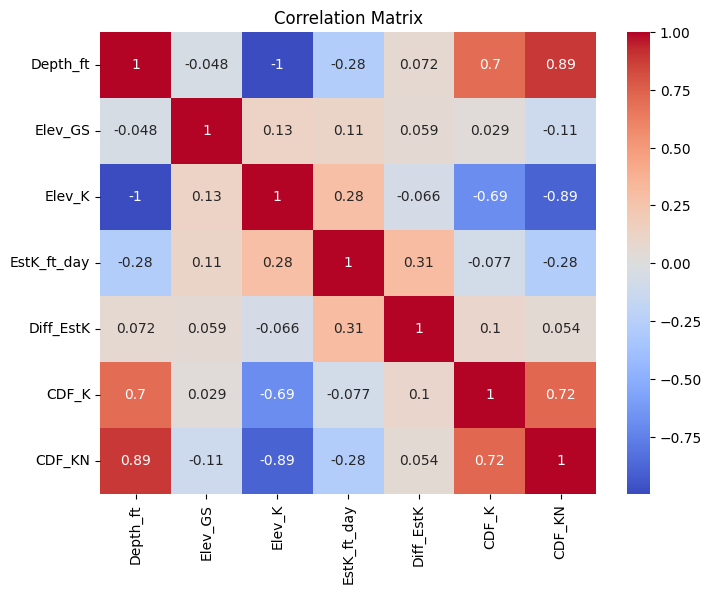

In [71]:
# Correlation matrix between variables.
plt.figure(figsize=(8, 6))
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


The strongest positive/negative (non-one) correlations here are Depth_ft and CDF_KN. This is a bit distracting, because CDF_KN is a cumulative score based on increasing depth, so this correlation is not likely helpful in determining potential comparisons for machine learning. However, by reviewing the initial EstK and the Depth_ft (-0.28) versus the difference in the difference of the consecutive DiffEstK by Depth_ft (0.072) the correlation is less strong. I evaluated some other plots to see if any other patterns were helpful including a joint scatter/histogram plot, and a joint hex/histogram plot. Of the two the hexplot showed the density of the points best.


## Figure 14.  Hexbin Plot


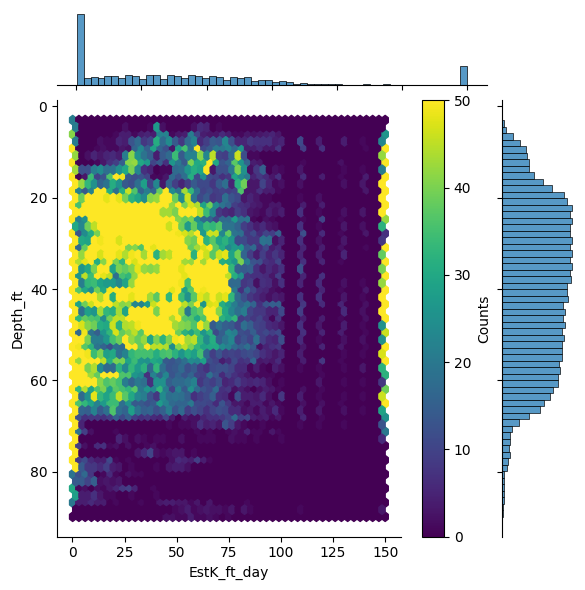

In [72]:
# Create a hexbin plot for larger datasets with overlapping points with adjusted color map
hexbin_plot = sns.jointplot(x='EstK_ft_day', y='Depth_ft', data=df, kind='hex', cmap='viridis')

# Adjust the color map to better stretch across the plot
hexbin_plot.ax_joint.collections[0].set_clim(0, 50)

# Invert the Y-axis
hexbin_plot.ax_joint.invert_yaxis()

# Add a color bar legend
cbar = plt.colorbar(hexbin_plot.ax_joint.collections[0], ax=hexbin_plot.ax_joint)
cbar.set_label('Counts')

plt.show()


The Hex joint plot really confirms the observation that most of the estimated K data (from the entire dataset) is representative of lower permeability.  And this also shows that the thickest band of low permeability happens between 20 and 50 ft below ground surface.  

So, we have looked at this raw data in many different ways.  We understand its basic statistics as a whole data file, and some of the relationships parsed out on location by location.  Additional steps may be to calculate thickness where a step change in gradient of the CDF occurs.

#4.0 Unsupervised Machine Learning

Now let's start looking at unsupervised clustering to see what we can find.  Kmeans is the most used version.  However, it may not be suitable for linear data as it tends to cluster based on circles.  But let's see what happens.

## Figure 15.  KMeans by Location - 3 Clusters

In [73]:
color_dictML = {
    0: '#7DF9FF',  # C1: Electric blue
    1: '#93C572',  # C2: Pistachio
    2: 'peru'      # C3: Orangish brown (unchanged)
}
# Add a new entry for values greater than 2
color_dictML.update((k, 'black') for k in range(3, 1000))  # Assuming values won't exceed 1000
color_dictML[-1] = 'black'  # Specifically assign black to -1

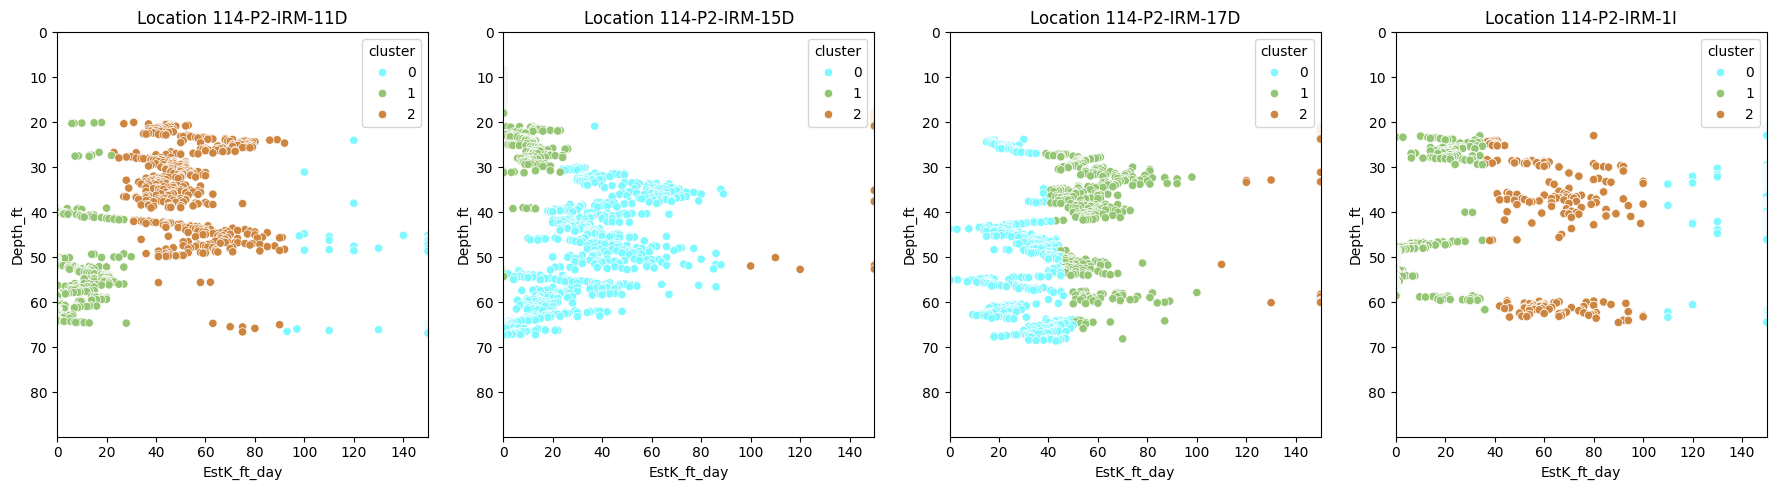

In [74]:
# create df group by Location_ID, then run Kmeans using 3 clusters on EstK_ft_day and Depth_ft, and then create subplots with 4 columns, and for all plots, make X axes the max of all from EstK_ft_day, and make Y axes the max of all from  Depth_ft, and invert all of the Y axes

# Group data by Location_ID because grouping was overwritten above
grouped = df.groupby('Location_ID')

# Create subplots with 4 columns, limiting to 4 plots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 5))  # Changed nrows to 1
axes = axes.flatten()

# Define x and y axis limits for all plots
x_max = df['EstK_ft_day'].max()
y_max = df['Depth_ft'].max()

# Iterate through only the first 4 groups
for i, (location, data) in enumerate(grouped):
    if i >= 4:  # If 4 plots are already shown, break out of loop
        break
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(data[['EstK_ft_day', 'Depth_ft']])
    data['cluster'] = kmeans.labels_

    # Plotting
    sns.scatterplot(ax=axes[i], x='EstK_ft_day', y='Depth_ft', hue='cluster', data=data, palette=color_dictML)
    axes[i].set_title(f'Location {location}')
    axes[i].set_xlim(0, x_max)
    axes[i].set_ylim(0, y_max)
    axes[i].invert_yaxis()

plt.tight_layout()
plt.show()

 As I thought, this does not look like geology by depth.  There is really no need to calculate a silhouette width score for this because it is no-way suitable.

 Also note that every plot has a different cluster assignment.  Cluster 0, which should represent the highest permeability (C1 label from above), and although Cluster 0 is showing as blue on every plot, Cluster 0 does not necessarily represent the highest EstK cluster from plot to plot.  Cluster 1 (green) should represent the middle permeability ranges (C2 label).  And Cluster 2 should represent the lowest permeabilities (C3 label/brown).  What does this mean?  It means that the cluster assignment from plot to plot would be invalid and not comparable!!  That is terrible!

 But *The Hundred-page Machine Learning Book* by Andriy Burkov recommends trying the HDBScan every time.  So, let's try that.


 ## Figure 16.  HDBScan By Location - 3 Clusters


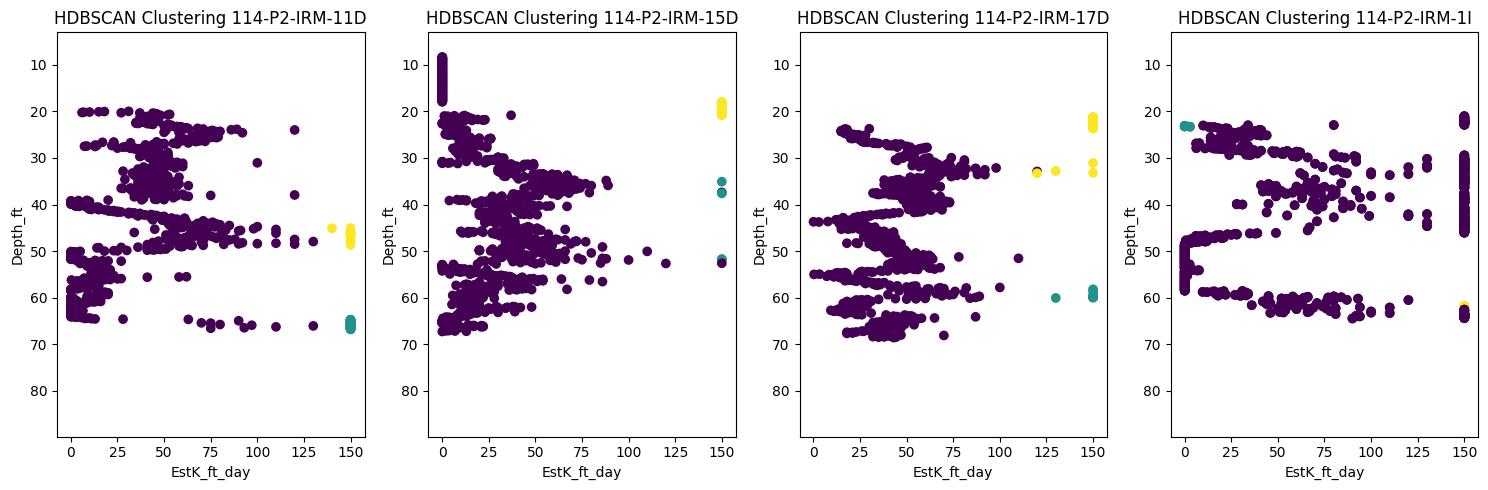

In [75]:
# Create subplots with 4 columns, limiting to 4 plots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))  # Changed nrows to 1, sharey removed
axes = axes.flatten()

# Get the minimum and maximum depth values across all groups.
y_min = df['Depth_ft'].min()
y_max = df['Depth_ft'].max()

# Run HDBSCAN for each group and plot in the subplot, limiting to the first 4
for i, (name, group) in enumerate(df.groupby('Location_ID')):
    if i >= 4:  # If 4 plots are already shown, break out of loop
        break

    X = group[['EstK_ft_day', 'Depth_ft']]

    # Run HDBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=3)
    cluster_labels = clusterer.fit_predict(X)

    # If more than 3 clusters are found, reassign to -1 (noise) for extra clusters
    unique_clusters = np.unique(cluster_labels)
    if len(unique_clusters) > 4:  # Account for noise cluster (-1)
        for cluster in unique_clusters[3:]:  # Start from the 4th cluster
            cluster_labels[cluster_labels == cluster] = -1

    # Add the cluster labels to the group
    group['Cluster'] = cluster_labels

    # Plot the clusters in the subplot
    ax = axes[i]
    # Change here: Use cmap instead of palette for ax.scatter
    scatter = ax.scatter(group['EstK_ft_day'], group['Depth_ft'], c=group['Cluster'], cmap='viridis', label=f'Location {name}') #using 'viridis' but any suitable cmap could work.
    ax.set_xlabel('EstK_ft_day')
    ax.set_ylabel('Depth_ft')
    ax.set_title(f'HDBSCAN Clustering {name}')

    # Invert the Y-axis to have the origin at the upper left
    ax.invert_yaxis()

    # Set the same Y-axis limits for all subplots.
    ax.set_ylim(y_max, y_min)

plt.tight_layout()
plt.show()

This really doesn't seem to honor the layering that I am trying to get the clustering to pick up on.  Initially, HDBScan wanted to select a cluster of 5, so I forced it to assign anything above 3 as noise.  But that also did not reveal the patterns that I was expecting.  Further, the cluster assignment relative to EstK is still not consistent from plot to plot.  

However, Gaussian Mixture and Spectral Clustering are known to be able to cluster based on elongate or linear features (SciKitLearnB 2024).  So let's try them.

## Figure 17. Gaussian Mixture Method By Location (3 Clusters)

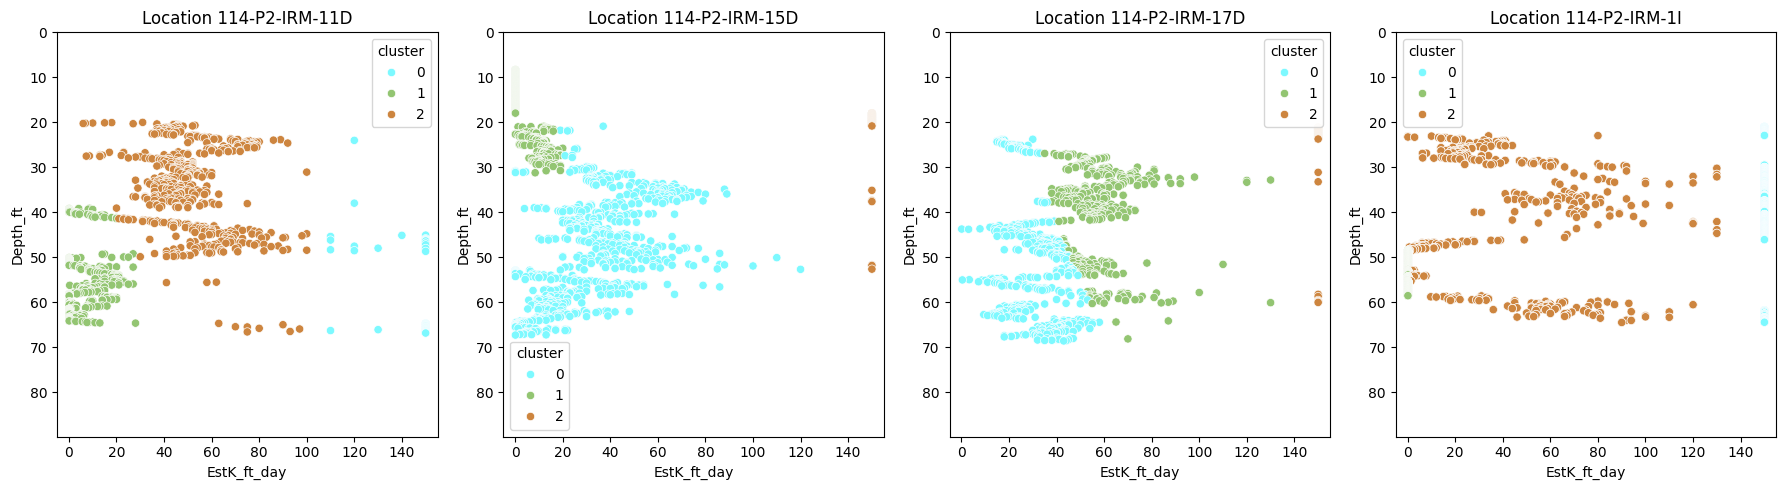

In [76]:
# Create subplots with 4 columns, limiting to 4 plots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 5))  # Changed nrows to 1
axes = axes.flatten()

# Define x and y axis limits for all plots
x_min = -5  # Set minimum x-axis limit to 0
x_max = 155  # Set maximum x-axis limit to 150
y_max = df['Depth_ft'].max()

# Iterate through only the first 4 groups
for i, (location, data) in enumerate(grouped):
    if i >= 4:  # If 4 plots are already shown, break out of loop
        break

    # Gaussian Mixture Model with 3 clusters
    gmm = GaussianMixture(n_components=3, random_state=0)
    gmm.fit(data[['EstK_ft_day', 'Depth_ft']])
    data['cluster'] = gmm.predict(data[['EstK_ft_day', 'Depth_ft']])

    # Plotting
    sns.scatterplot(ax=axes[i], x='EstK_ft_day', y='Depth_ft', hue='cluster', data=data, palette=color_dictML)
    axes[i].set_title(f'Location {location}')
    axes[i].set_xlim(x_min, x_max)  # Set x-axis limits
    axes[i].set_ylim(0, y_max)
    axes[i].invert_yaxis()

plt.tight_layout()
plt.show()

Other than the continued cluster/EstK value plot to plot inconsistencies, there are some good characteristics here.  For example, it is clustering low Estimated K in clusters, and some of the highest values in clusters together, but there are still some places where there are anomalies.  Sometimes this can be to the wrong model, of the wrong number of clusters.  More clusters were tried, but for brevity are not presented as graphs.

So Gaussian Mixture does an OK job, better than KMeans, but still does not look like consistently like layered deposition.  So, let's try Spectral Clustering.

## Figure 18. Spectral Clustering By Location:  3 Clusters

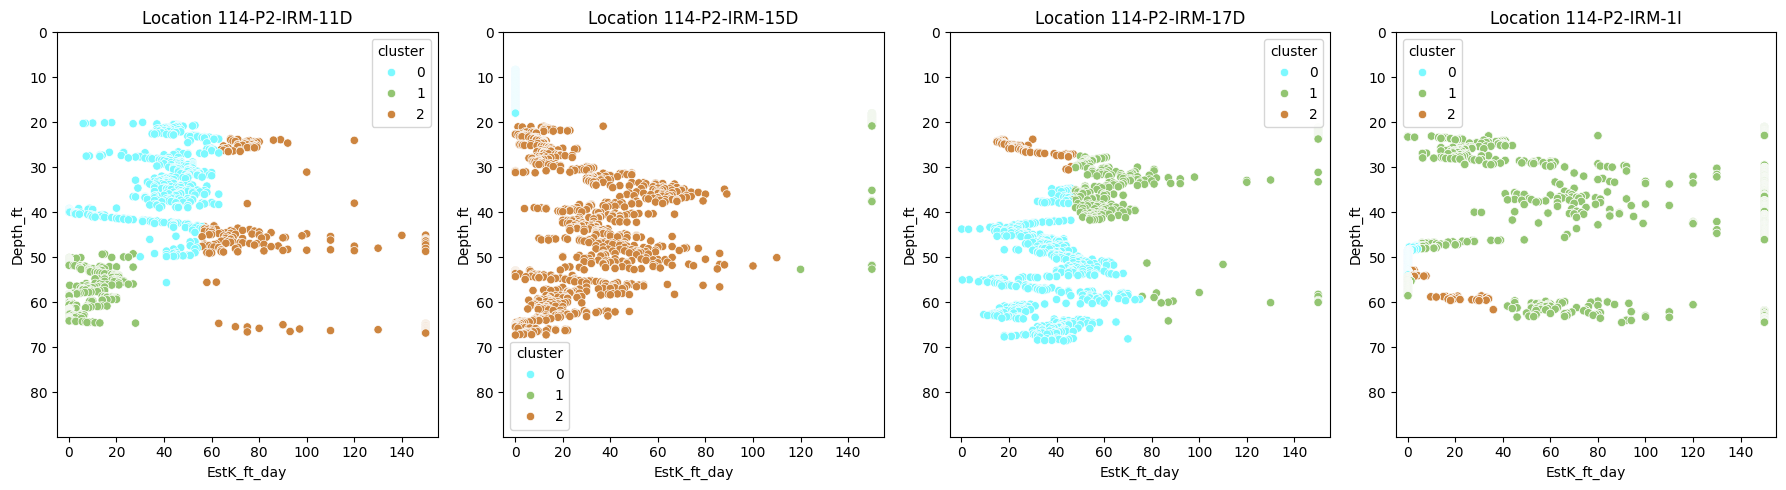

In [77]:
# Create subplots with 4 columns, limiting to 4 plots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 5))  # Changed nrows to 1
axes = axes.flatten()

# Define x and y axis limits for all plots
x_min = -5  # Set minimum x-axis limit to 0
x_max = 155  # Set maximum x-axis limit to 150
y_max = df['Depth_ft'].max()

# Iterate through only the first 4 groups
for i, (location, data) in enumerate(grouped):
    if i >= 4:  # If 4 plots are already shown, break out of loop
        break

    # Spectral Clustering with 3 clusters
    X = data[['EstK_ft_day', 'Depth_ft']]
    affinity_matrix = kneighbors_graph(X, n_neighbors=10, mode='connectivity')
    spectral_clustering = SpectralClustering(n_clusters=3, affinity='precomputed', random_state=0) # Changed to precomputed
    data['cluster'] = spectral_clustering.fit_predict(affinity_matrix)

    # Plotting
    sns.scatterplot(ax=axes[i], x='EstK_ft_day', y='Depth_ft', hue='cluster', data=data, palette=color_dictML)
    axes[i].set_title(f'Location {location}')
    axes[i].set_xlim(x_min, x_max)  # Set x-axis limits
    axes[i].set_ylim(0, y_max)
    axes[i].invert_yaxis()

plt.tight_layout()
plt.show()

The Spectral Clustering Looks Better.  It still in not perfect, but better. Varying clusters were visualized, but again are not shown as plots herein, but are included in scoring below.  The biggest downside for all of these (which may be remedied with continued research) lies in the inconsistent application of cluster labels without regard to the EstK range and the ranges from location to location.

You can also try using different affinities such as nearest neighbors, or precomputed.  I went with precomputed nearest neighbors as it seemed to best suit the data considering it will "interpret X as a sparse graph of precomputed distances and construct a binary affinity matrix from the nearest neighbors of each instance (SciKitLearnA 2024).  The precomputed nearest neighbors also require the construction of a square matrix.  So that was added.  I cycled through the different affinity types and generated a score for each.  

Each of these has some error.  Some of the error may be in the model.  Some may be in the number of clusters being appropriate for each location.  A silhouette width score will clarify the degree of similarity between the clusters. These were completed for 5 clusters and for different affinities, but code is hidden below.  For presentation, I selected showing the spectral clustering results for 3, 4, and 5 clusters using the precomputed nearest neighbor affinity.   

## Table 1:  Silhouette Width for 3, 4, & 5 Clusters Using Spectral Clustering (Precomputed Nearest Neighbor)

In [78]:
def calculate_silhouette_scores(group):
    """Calculates silhouette scores for 3, 4, and 5 clusters using Spectral Clustering."""
    X = group[['EstK_ft_day', 'Depth_ft']]
    affinity_matrix = kneighbors_graph(X, n_neighbors=10, mode='connectivity')
    affinity_matrix = 0.5 * (affinity_matrix + affinity_matrix.T)  # Ensure symmetry

    scores = []
    for n_clusters in [3, 4, 5]:
        spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed_nearest_neighbors')
        labels = spectral.fit_predict(affinity_matrix)
        scores.append(silhouette_score(X, labels))

    return pd.Series({'Clusters_3': scores[0], 'Clusters_4': scores[1], 'Clusters_5': scores[2]})


In [79]:
# Calculate silhouette scores for each group, silencing the deprecation warning
silhouette_scores_df = grouped.apply(calculate_silhouette_scores, include_groups=False).reset_index()

silhouette_scores_df.head(4)

,Location_ID,Clusters_3,Clusters_4,Clusters_5
0,114-P2-IRM-11D,0.481991,0.437667,0.372690
1,114-P2-IRM-15D,0.192436,0.323292,0.321011
2,114-P2-IRM-17D,0.290547,0.405898,0.362879
3,114-P2-IRM-1I,-0.392525,-0.453095,-0.061197


It may be helpful to summarize this with some descriptive statistics and some probability density functions, and histograms to visualize the distributions.  

In [80]:
# Calculate descriptive statistics of silhouette width options
SWdescriptive_stats = silhouette_scores_df.describe()
print("\nDescriptive Statistics of Silhouette Width Clusters Using Precomputed Nearest Neighbors:")
print(SWdescriptive_stats)


Descriptive Statistics of Silhouette Width Clusters Using Precomputed Nearest Neighbors:
       Clusters_3  Clusters_4  Clusters_5
count   51.000000   51.000000   51.000000
mean     0.332078    0.315730    0.340179
std      0.199078    0.184560    0.131716
min     -0.392525   -0.453095   -0.061197
25%      0.207064    0.259513    0.302138
50%      0.334998    0.346852    0.365730
75%      0.475773    0.434281    0.414328
max      0.820057    0.560738    0.565885


Based on interpreting silhouette width scores, very few of these scores are close to 1.  Most are above zero, so not many overlapping clusters, or many negative values indicating they have been assigned to the wrong cluster.  But, still not great.  So how do we know which one to choose?  By plotting the probability density function and the histogram, it may be clearer as to which is the right number of clusters.  

## Figure 19.  Line Graph of Spectral Clustering Scores

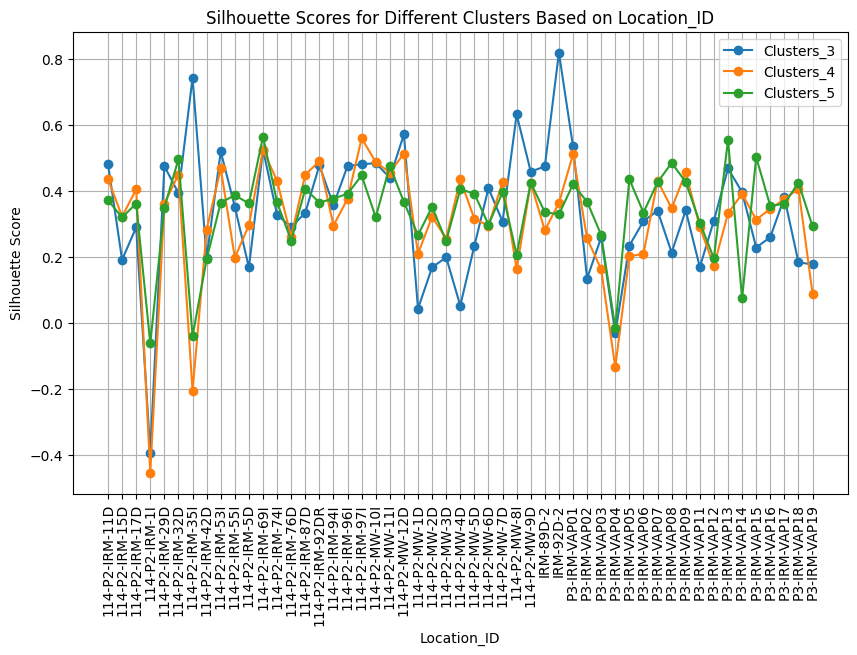

In [81]:
# Plotting the line graph based on Location_ID
plt.figure(figsize=(10, 6))
plt.plot(silhouette_scores_df['Location_ID'], silhouette_scores_df['Clusters_3'], label='Clusters_3', marker='o')
plt.plot(silhouette_scores_df['Location_ID'], silhouette_scores_df['Clusters_4'], label='Clusters_4', marker='o')
plt.plot(silhouette_scores_df['Location_ID'], silhouette_scores_df['Clusters_5'], label='Clusters_5', marker='o')

plt.title('Silhouette Scores for Different Clusters Based on Location_ID')
plt.xlabel('Location_ID')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90, fontsize=10)
plt.show()


Figure 19 illustrates the locations where alignment occurs in the silhouette width score (when all three points follow the same pattern) and those locations where the clustering makes a more variable impact.  Review of these variations, such as at 114-P2-IRM-97I, would be good to review on the individual graphs.  The overall mean of the silhouette width scores within Cluster 5 method is closest to 1.  But it is still very low at 0.33.  So, it may be best to choose which is the best cluster number on a location by location basis.     

## Figure 20.  Histogram of Spectral Clustering Scores

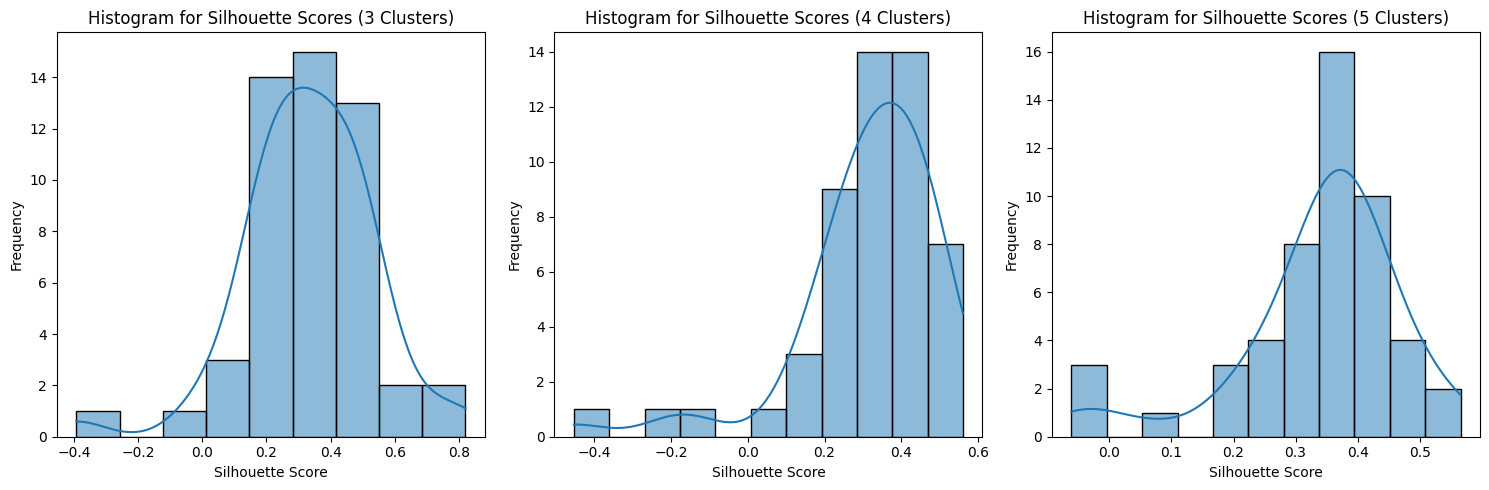

In [82]:
# Create a subplot of 3 histograms for Clusters_3, Clusters_4, and Clusters_5
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Histogram for Clusters_3
sns.histplot(silhouette_scores_df['Clusters_3'], ax=axes[0], kde=True)
axes[0].set_title('Histogram for Silhouette Scores (3 Clusters)')
axes[0].set_xlabel('Silhouette Score')
axes[0].set_ylabel('Frequency')

# Histogram for Clusters_4
sns.histplot(silhouette_scores_df['Clusters_4'], ax=axes[1], kde=True)
axes[1].set_title('Histogram for Silhouette Scores (4 Clusters)')
axes[1].set_xlabel('Silhouette Score')
axes[1].set_ylabel('Frequency')

# Histogram for Clusters_5
sns.histplot(silhouette_scores_df['Clusters_5'], ax=axes[2], kde=True)
axes[2].set_title('Histogram for Silhouette Scores (5 Clusters)')
axes[2].set_xlabel('Silhouette Score')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Based on the histograms, three clusters seem to have the closest approximation to a normal distribution.  But remember, this is not normal data.  This is deposition data.  So is three the best? Maybe??  

But maybe we should go back to the Difference Variable and rerun Spectral Clustering and the Silhouette Width scores for that.  


## Figure 21. Spectral Clustering: 5 Clusters Using Difference of Consecutive Estimated K (Precomputed Neareast Neighbors Affinity)

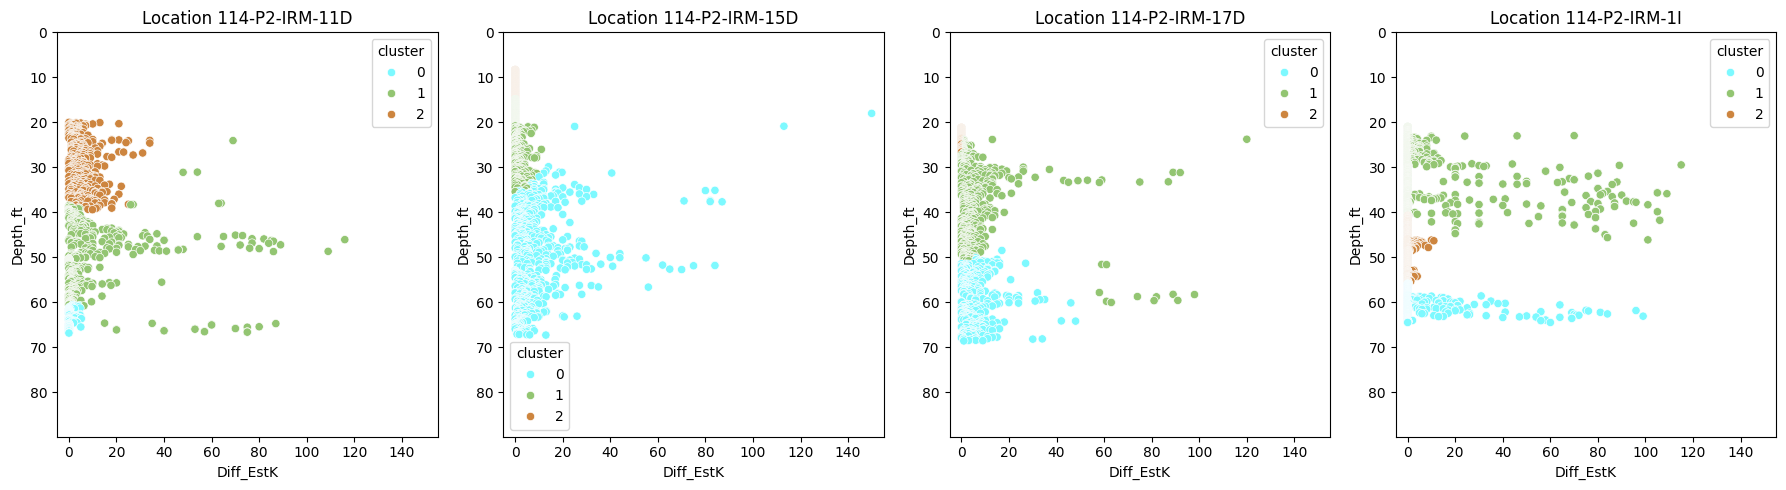

In [83]:
# Create subplots with 4 columns, limiting to 4 plots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 5))  # Changed nrows to 1
axes = axes.flatten()

# Define x and y axis limits for all plots
x_min = -5  # Set minimum x-axis limit to 0
x_max = 155  # Set maximum x-axis limit to 150
y_max = df['Depth_ft'].max()

# Iterate through only the first 4 groups
for i, (location, data) in enumerate(grouped):
    if i >= 4:  # If 4 plots are already shown, break out of loop
        break
    # Spectral Clustering with 3 clusters
    X = data[['Diff_EstK', 'Depth_ft']]
    affinity_matrix = kneighbors_graph(X, n_neighbors=10, mode='connectivity')
    spectral_clustering = SpectralClustering(n_clusters=3, affinity='precomputed', random_state=0)  # Changed to 'precomputed'
    data['cluster'] = spectral_clustering.fit_predict(affinity_matrix)

    # Plotting
    sns.scatterplot(ax=axes[i], x='Diff_EstK', y='Depth_ft', hue='cluster', data=data, palette=color_dictML)
    axes[i].set_title(f'Location {location}')
    axes[i].set_xlim(x_min, x_max)  # Set x-axis limits
    axes[i].set_ylim(0, y_max)
    axes[i].invert_yaxis()

plt.tight_layout()
plt.show()

Figure 21 looks better than Figure 18 when using the Difference in EstK rather than the actual. But, again visually one can probably see that it is not perfect. The clusters are honoring some of the horizontality, but not completely. Is the scoring for Difference of EstK better?

## Table 2:  Silhouette Width for 3, 4, & 5 Clusters Using Spectral Clustering (Precomputed Nearest Neighbor) Based on Difference of EstK

In [84]:
def calculate_silhouette_scores2(group):
    """Calculates silhouette scores for 3, 4, and 5 clusters using Spectral Clustering."""
    X = group[['Diff_EstK', 'Depth_ft']]
    affinity_matrix = kneighbors_graph(X, n_neighbors=10, mode='connectivity')
    affinity_matrix = 0.5 * (affinity_matrix + affinity_matrix.T)  # Ensure symmetry

    scores = []
    for n_clusters in [3, 4, 5]:
        spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed_nearest_neighbors')
        labels = spectral.fit_predict(affinity_matrix)
        scores.append(silhouette_score(X, labels))

    return pd.Series({'Clusters_3': scores[0], 'Clusters_4': scores[1], 'Clusters_5': scores[2]})


In [85]:
# Calculate silhouette scores for each group, silencing the deprecation warning
silhouette_scores_df2 = grouped.apply(calculate_silhouette_scores2, include_groups=False).reset_index()

silhouette_scores_df2.head(4)

,Location_ID,Clusters_3,Clusters_4,Clusters_5
0,114-P2-IRM-11D,0.310111,0.422324,0.320454
1,114-P2-IRM-15D,0.335947,0.354886,0.261155
2,114-P2-IRM-17D,0.265267,0.251742,0.272114
3,114-P2-IRM-1I,0.286002,0.202757,0.175554


In [86]:
# Calculate descriptive statistics of silhouette width options
SWdescriptive_stats2 = silhouette_scores_df2.describe()
print("\nDescriptive Statistics of Diff EstK Silhouette Width Clusters Using Precomputed Nearest Neighbors:")
print(SWdescriptive_stats2)
SWdescriptive_stats = silhouette_scores_df.describe()
print("\nDescriptive Statistics of Actual EstK Silhouette Width Clusters Using Precomputed Nearest Neighbors:")
print(SWdescriptive_stats)


Descriptive Statistics of Diff EstK Silhouette Width Clusters Using Precomputed Nearest Neighbors:
       Clusters_3  Clusters_4  Clusters_5
count   51.000000   51.000000   51.000000
mean     0.368566    0.336528    0.311025
std      0.105454    0.100972    0.059564
min      0.080497    0.008949    0.173224
25%      0.323060    0.299183    0.271298
50%      0.369500    0.348344    0.308774
75%      0.446833    0.407053    0.341907
max      0.546747    0.489205    0.429133

Descriptive Statistics of Actual EstK Silhouette Width Clusters Using Precomputed Nearest Neighbors:
       Clusters_3  Clusters_4  Clusters_5
count   51.000000   51.000000   51.000000
mean     0.332078    0.315730    0.340179
std      0.199078    0.184560    0.131716
min     -0.392525   -0.453095   -0.061197
25%      0.207064    0.259513    0.302138
50%      0.334998    0.346852    0.365730
75%      0.475773    0.434281    0.414328
max      0.820057    0.560738    0.565885


So, did it do better and address all the concerns?  Well, not really.  The Cluster 3 score is best of the three when using the Difference EstK, and it is a little better than the Silhouette Width Scores using the actual Estimated K data, but doesn't really improve the results that much.  

Are three clusters the best? Again, maybe??  Or, maybe there is still another method out there that will be able to solve this problem better in the future. Several papers have been written on the use of a method called:  Toeplitz Inverse Covariance-Based Clustering or TICC.  I evaluated the use of this model but ran into complications (as shown below) and was creating infinity numbers and the iterations never resulted in convergence.  Hallac et. al. wrote on its application with temporal data in 2017.  And really depth is like time-series data.  Bhattacharya (2022) applied the TICC model to petrophysical shear sonic wave forms.  This suggests great promise, but not within the scope of this assignment and is something to continue evaluating.

What does this mean for application at the site, where we expected to see 4 layers, and from that expected that 4 clusters may be an ideal number?  This suggests that one of the layers may be very thin, and not very pronounced as an independent cluster.  

And what about the inconsistent application of cluster labels making cross comparison from location to location difficult.  This will also be a topic for future research.  


# 5.0  Conclusion

In review, high resolution data like downhole measurements from HPT estimated K sensors provide large amounts of data to better understand what the possibility of horizontal and vertical extent of certain unconsolidated materials above bedrock. This study illustrated that standard clustering models like Kmeans and HDBScan do not fit the shape of the distribution of the data that occurs in nature represented by down-hole boring log charts. Gaussian Mixture and Spectral Clustering models which honor banded, or linear geometries and are a better fit for identifying potential clusters of associated data. However, even these models are not perfect, and offer limited confidence in being able to consistently select clusters that align to suspected groupings.  As earth-resource focused data scientists, we look forward to the continued evaluation of more refined models such as TICC in the future.

# 6.0 References:
Bhattacharya, S. (2022). Unsupervised time series clustering, class-based ensemble machine learning, and petrophysical modeling for predicting shear sonic wave slowness in heterogeneous rocks. *Society of Exploration Geophysicists*.

Burkov, A. (2019). *The Hundred-Page Machine Learning Book*. Self-published. ISBN: 9781999579500

Hallac, D. et al. (2017). Toeplitz Inverse Covariance-Based Clustering of
Multivariate Time Series Data.  *Association for Computing Machinery*.

SciKitLearnA. (2024). Spectral Clustering. Version 1.6.1.  https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

SciKitLearnB. (2024). Comparing different clustering algorithms on toy datasets.  Version 1.6.1. https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

#Questions

Which method did you like the most?

*I preferred Spectral Clustering as it best honored the linear clustering that I hoped to mimic.*

Which method did you like the least?

*I was very surprised about the results of HDBScan.  I was very hopeful about it after reading, and it did not honor the type of clusters that I was looking for at all.  It was very surprising.*

How did you score these unsupervised models?  
*Silhouette Width Scores were used to compare cluster numbers and models.*

Did the output align with your geologic understanding?

*Somewhat - I was expecting to be able to find an easy way to be able to interpret the data and align it to my expectations for over a year.  I still am not satisfied, but hopeful about the TICC method.*

What did you want to learn more about?

*I definitely want to keep researching the TICC method as applied by Bhattacharya.*

Did you pre-process your data?

*I evaluated preprocessing, including removing a potential questionable point, and log transforming.  But neither seemed appropriate.  I did end up clipping anything less than 1 from the lower limit of the data because I was having errors when I was testing the TICC method.  But without the TICC, I am not sure it really affected the results.  I may try re-running everything without the clipping next time, in a new notebook and see if the scores change.*

What was a decision you were most unsure about?

I saw a method about splitting up the area under the CDF curve into three segments (bins), and it seemed really important to the decisions of the engineers and geologists that actually work on this project. But I could not replicate it, or justify why they had done it.  I ended up leaving that analysis out.  I also removed the TICC analysis that I was attempting that demonstrated that the model never converged, nor could I get it to create any cluster graphs. That leads me to:  

I am unsure when we should report on our troubleshooting as it might be helpful to others, or when we should throw in the towel on certain code snippets and wait for a rematch.  

FOR FUTURE WORK INVOLVING TEMPORAL DATA OR ITS ANALOGS, SEE TICC

In [87]:
#!pip install ticc==0.1.4
#!git clone https://github.com/davidhallac/TICC.git

In [88]:
#import sys
#sys.path.append('TICC')  # Add the TICC directory to the system path
#from TICC_solver import TICC
#import tempfile
#import os